In [1]:
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt 
import matplotlib.patheffects as PathEffects
from matplotlib.colors import BoundaryNorm

import numpy as np

import xarray as xr

import netCDF4
from netCDF4 import Dataset, num2date

import metpy 
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section
from metpy.units import units

import datetime
from datetime import datetime as dt
from datetime import datetime, timedelta
import pandas as pd

import warnings
warnings.filterwarnings("ignore") 

import glob

import math

from wrf import to_np, getvar, CoordPair, vertcross, interpline


#import pyart
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import seaborn as sn

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#%config InlineBackend.figure_format='retina'
#plt.rcParams["font.family"] = "Arial"

In [2]:
###functions used to calculate basic trajectory calculations

#calculating the distance between points in a lat and lon array
#from troy so is correct for sure
#from brian... distance between two lat and lon points
#returns in km
def get_distll(lat1, lon1, lat2, lon2):
    Avg_Lat = 0.5*(lat1+lat2)
    Ydist = 111.*(lat1-lat2)
    Xdist = 111.*np.cos(Avg_Lat*np.pi/180.)*(lon1-lon2)
    Dist = np.sqrt(Xdist**2 + Ydist**2)
    return Dist
def getdist(dist1, dist2):
    Dist=dist2-dist1
    return Dist
#finding the next position
def next_position(Xo,Yo,W,T,U,t):
    X= Xo+(U*t)
    Y= Yo+(W*t)+(T*t)
    return(X,Y)
def great_circle(latitude, longitude):

    radius = 6372795.
    
    if len(latitude) == 2 & len(longitude) == 2:
        latr1, lonr1 = np.radians(latitude[0]), np.radians(longitude[0])
        latr2, lonr2 = np.radians(latitude[1]), np.radians(longitude[1])
    else:
        latr1, lonr1 = np.radians(latitude[1:]), np.radians(longitude[1:])
        latr2, lonr2 = np.radians(latitude[:-1]), np.radians(longitude[:-1])

    sin_lat1, cos_lat1 = np.sin(latr1), np.cos(latr1)
    sin_lat2, cos_lat2 = np.sin(latr2), np.cos(latr2)

    delta_lon = lonr2 - lonr1
    cos_delta_lon, sin_delta_lon = np.cos(delta_lon), np.sin(delta_lon)

    d = np.arctan2(np.sqrt((cos_lat2 * sin_delta_lon) ** 2 +
                           (cos_lat1 * sin_lat2 -
                            sin_lat1 * cos_lat2 * cos_delta_lon) ** 2),
                   sin_lat1 * sin_lat2 + cos_lat1 * cos_lat2 * cos_delta_lon)

    return radius * d
#finding closer distance to left of plot and farther distance to right of distance wanted
def distance_i(distance_wanted, dist_array):
    diff=np.zeros(dist_array.shape[0])
    for n in range(dist_array.shape[0]):
        diff[n]=distance_wanted-dist_array[n]
        if diff[n]>=0:
            closest=np.min(diff[n])

    before_i=np.where(diff==closest)
    after_i=before_i[0]+1
    return (before_i[0], after_i)
#finding the index of the height above and below the intersection point (for wcr and sounding)
def height_i(height_wanted, array):
    pos_diff=[]
    neg_diff=[]
    height_diff=height_wanted-array[0,:]
    for j in range(height_diff.shape[0]):
        if height_diff[j]>=0:
            pos_diff.append(height_diff[j])
        if height_diff[j]<0:
            neg_diff.append(height_diff[j])
    pos_diff= np.asarray(pos_diff)
    neg_diff= np.asarray(neg_diff)

    if np.min(pos_diff)<np.min(np.abs(neg_diff)):
        loweri=np.where(height_diff==np.min(pos_diff))[0]
        upperi=loweri+1
    if np.min(pos_diff)>np.min(np.abs(neg_diff)):
        upperi=np.where(height_diff==np.max(neg_diff))[0]
        loweri=upperi-1
    return(loweri, upperi)
#finding the angle at point (radians), u, or v on the sounding at a specific level and location
def value_at_point_1d(A, B, dist_h_wanted, dist_or_h, variable):
    A_to_point=dist_h_wanted-dist_or_h[A]
    A_to_B= dist_or_h[B]-dist_or_h[A]
    ABfraction=A_to_point/A_to_B
    
    Aa=variable[A]
    Ba=variable[B]
    ABvalue= Aa+(ABfraction)*(Ba-Aa)
    return(ABvalue)
#final wind
def shifted_wind(u,v,rad_angle):
    ucomp=u*math.cos(rad_angle)
    vcomp=v*math.sin(rad_angle)
    wind=ucomp+vcomp
    return(wind)
#becuase the WCR and flight data have different shapes (and thus distances are different) the two thing that relates the two is time
#must find the time at the distance of the intersection to be able to move the seeding particle through the WCR data based on time
def wcr_time_i(before_i, after_i, distance_wanted):
    #calculating the distance between the points surrounding the intersection point
    distance_traveled=distance[after_i]-distance[before_i]
    #calculating the distance from the point before and the intersection point
    dwanted= distance_wanted-distance[before_i]

    #time of the flight at the points before and after the intersection point
    flight_time_before=df_flight_time_subset[before_i,0]
    flight_time_after=df_flight_time_subset[after_i,0]

    #calculating the time difference between the points on either side of the intersection point
    time_diff=str(flight_time_after-flight_time_before) #time diff in nano seconds
    time_diff=np.float(time_diff[1:-1])/1000000000 #convert to seconds

    #setting the units so that it is seconds since the point before the intersction point
    flight_date_before= np.str(flight_time_before)
    time_units= np.str('seconds since '+flight_date_before[2:12]+' '+flight_date_before[13:21])

    #calculating the time it takes to travel from the point before to the intersection point... esentially finds the speed of the airplane between the before and after point and using that speed
    #it calculates how long it takes the plane to get to the intersection point
    #time_diff= time between points surrounding intersection point
    #distance_traveled= distance between points before and after the intersection point
    #dwanted= distance from point before to the intersection point
    before_to_point_time=before_dwanted_time(time_diff, distance_traveled, dwanted)

    #using the units set before to find the time of at the intersection point
    date_at_point= netCDF4.num2date(before_to_point_time,units = time_units)

    #filling an array the same shape as the WCR time date with the value that we found
    date_at_point_a=np.full(shape=time_subset_2d_wcr.shape[0],fill_value=date_at_point)
    date_at_point_dt= np.asarray(pd.to_datetime(date_at_point_a.astype(str)))

    #finding the difference between time of intersection and each time in the WCR data
    wcr_fl_time_diff=np.asarray(date_at_point_dt-time_subset_2d_wcr[:,0]) #difference is in nanoseconds

    #going through and finding the smalles differnce
    for n in range(wcr_fl_time_diff.shape[0]):
        if wcr_fl_time_diff[n].astype(float)>=0:
            new_diff_min=np.min(wcr_fl_time_diff[n])
    t_before= np.where(wcr_fl_time_diff==new_diff_min)[0]
    t_after=t_before+1
    return(date_at_point_dt[0], t_before, t_after)
#interpolating to find the W,u,v at the wanted height and distance (WRF)
def final_w_u_v(close_WRF, far_WRF, distance_wanted, lower, upper, height_wanted,v):
    A_to_point= getdist(wrf_distance[close_WRF], distance_wanted)
    A_to_B= getdist(wrf_distance[close_WRF], wrf_distance[far_WRF])
    ABfraction=A_to_point/A_to_B
    
    C_to_point= getdist(wrf_distance[close_WRF], distance_wanted)
    C_to_D= getdist(wrf_distance[close_WRF], wrf_distance[far_WRF])
    CDfraction=C_to_point/C_to_D
    
    D_to_point= getdist(wrf_height_a[lower,0],height_wanted)
    D_to_B= getdist(wrf_height_a[lower,0], wrf_height_a[upper,0])
    DBfraction=D_to_point/D_to_B
    
    Av=v[upper,close_WRF]
    Cv=v[lower, close_WRF]
    Dv=v[lower,far_WRF]
    Bv=v[upper, far_WRF]
    ABvalue= Av+(ABfraction)*(Bv-Av)
    CDvalue= Cv+(CDfraction)*(Dv-Cv)
    finalvalue=CDvalue+(DBfraction)*(ABvalue-CDvalue)
    final_value=finalvalue
    return(final_value)

#putting everything togther to get next position
def put_it_all_together(distance_wanted, height_wanted,t):
    [loweri_wcr, upperi_wcr]=height_i(height_wanted, gate_subset_wcr)
    [loweri_wrf, upperi_wrf]=height_i(height_wanted, wrf_height_calcs)
    #[loweri_s, upperi_s]= height_i(height_wanted, height_v_sec_sounding_a)
    [closex_wcr, farx_wcr]=distance_i(distance_wanted, distance)
    [closex_wrf, farx_wrf]=distance_i(distance_wanted, wrf_distance)
    [time_at_point, before_t_i, after_t_i]=wcr_time_i(closex_wcr, farx_wcr, distance_wanted)
    angle_at_pt=value_at_point_1d(closex_wcr, farx_wcr, distance_wanted, distance, a_subset)
    u_at_pt=final_w_u_v(closex_wrf, farx_wrf, distance_wanted, loweri_wrf, upperi_wrf, height_wanted, wrf_u_a)
    v_at_pt=final_w_u_v(closex_wrf, farx_wrf, distance_wanted, loweri_wrf, upperi_wrf, height_wanted, wrf_v_a)
    
    w= final_v(time_at_point,before_t_i, after_t_i, distance_wanted, loweri_wcr, upperi_wcr, height_wanted,w_a)
    T= final_v(time_at_point,before_t_i, after_t_i, distance_wanted, loweri_wcr, upperi_wcr, height_wanted,T_a)
    along_fl_wind= shifted_wind(u_at_pt, v_at_pt, angle_at_pt)
    
    [d, h]=next_position(distance_wanted,height_wanted,w,T,along_fl_wind,t)
    return(d,h,w)

##just for WCR 
#finding time of the distance wanted
def before_dwanted_time(t,d,dw):
    rate=d/t
    time=dw/rate
    return time
#finding time difference for interpolation
def time_diff_interp(t_wanted_or_far, t_close):
    diff=np.float(str(t_wanted_or_far-t_close)[1:-1])/1000000000
    return(diff)
#interpolating to find W and T at time and height wanted
def final_v(time_at_point, before_t_i, after_t_i, distance_wanted, loweri_wcr, upperi_wcr, height_wanted,v):
    A_to_point= time_diff_interp(time_at_point, time_subset_2d_wcr[before_t_i,upperi_wcr])
    A_to_B= time_diff_interp(time_subset_2d_wcr[after_t_i,upperi_wcr], time_subset_2d_wcr[before_t_i,upperi_wcr])
    ABfraction=A_to_point/A_to_B #CD and AB fraction is the same

    D_to_point= height_wanted-gate_subset_wcr[0,loweri_wcr]
    D_to_B= gate_subset_wcr[0,upperi_wcr]-gate_subset_wcr[0,loweri_wcr]
    DBfraction=D_to_point/D_to_B

    Av=v[before_t_i,upperi_wcr]
    Cv=v[before_t_i, loweri_wcr]
    Dv=v[after_t_i, loweri_wcr]
    Bv=v[after_t_i, upperi_wcr]
    ABvalue= Av+(ABfraction)*(Bv-Av)
    CDvalue= Cv+(ABfraction)*(Dv-Cv)
    finalvalue=CDvalue+(DBfraction)*(ABvalue-CDvalue)
    return(finalvalue)

In [3]:
###### Inital Variables Needed for File Read In 
rf = 'RF16'
rf2=16


if rf == 'RF01':
    iop_t =  [['2017-01-08 02:45:11', '2017-01-08 02:56:13', '1', 0],
              ['2017-01-08 03:00:04', '2017-01-08 03:16:16', '2', 1],
              ['2017-01-08 03:20:02', '2017-01-08 03:27:36', '3', 0],
              ['2017-01-08 03:31:01', '2017-01-08 03:50:56', '4', 1],
              ['2017-01-08 03:54:14', '2017-01-08 04:05:13', '5', 0],
              ['2017-01-08 04:07:33', '2017-01-08 04:29:13', '6', 1],
              ['2017-01-08 04:31:48', '2017-01-08 04:43:01', '7', 0],
              ['2017-01-08 04:45:36', '2017-01-08 05:06:50', '8', 1],
              ['2017-01-08 05:09:18', '2017-01-08 05:21:00', '9', 0],
              ['2017-01-08 05:23:06', '2017-01-08 05:40:08', '10', 1]]

if rf == 'RF02':
    iop_t = [['2017-01-09 04:38:24', '2017-01-09 04:46:01', '1', 0], #going north east
             ['2017-01-09 04:50:13', '2017-01-09 05:06:07', '2', 1], #going south west
             ['2017-01-09 05:09:57', '2017-01-09 05:17:24', '3', 0],
             ['2017-01-09 05:21:10', '2017-01-09 05:38:02', '4', 1],
             ['2017-01-09 05:42:35', '2017-01-09 05:50:27', '5', 0],
             ['2017-01-09 05:54:28', '2017-01-09 06:13:55', '6', 1],
             ['2017-01-09 06:18:18', '2017-01-09 06:28:08', '7', 0],
             ['2017-01-09 06:32:49', '2017-01-09 06:50:20', '8', 1],
             ['2017-01-09 06:54:36', '2017-01-09 07:04:51', '9',0],
             ['2017-01-09 07:09:18', '2017-01-09 07:26:38','10',1]]

if rf == 'RF03':
    iop_t = [['2017-01-11 02:48:36', '2017-01-11 03:03:39', '1', 0],
             ['2017-01-11 03:06:36', '2017-01-11 03:24:18', '2', 1],
             ['2017-01-11 03:27:18', '2017-01-11 03:34:15', '3', 0],
             ['2017-01-11 03:37:30', '2017-01-11 03:51:43', '4', 1],
             ['2017-01-11 03:55:12', '2017-01-11 04:02:52', '5', 0],
             ['2017-01-11 04:06:36', '2017-01-11 04:21:11', '6', 1],
             ['2017-01-11 04:24:50', '2017-01-11 04:35:35', '7', 0],
             ['2017-01-11 04:39:36', '2017-01-11 04:58:23', '8', 1],
             ['2017-01-11 05:01:48', '2017-01-11 05:12:54', '9', 0],
             ['2017-01-11 05:16:48', '2017-01-11 05:28:12','10', 1]]

if rf == 'RF04':
    iop_t = [['2017-01-18 20:16:12', '2017-01-18 20:31:19', '1', 0],
             ['2017-01-18 20:34:23', '2017-01-18 20:50:20', '2', 1],
             ['2017-01-18 20:54:18', '2017-01-18 21:05:02', '3', 0],
             ['2017-01-18 21:07:37', '2017-01-18 21:24:32', '4', 1],
             ['2017-01-18 21:27:54', '2017-01-18 21:38:17', '5', 0],
             ['2017-01-18 21:41:42', '2017-01-18 21:57:32', '6', 1],
             ['2017-01-18 22:00:18', '2017-01-18 22:11:42', '7', 0],
             ['2017-01-18 22:14:24', '2017-01-18 22:30:29', '8', 1],
             ['2017-01-18 22:33:36', '2017-01-18 22:43:37', '9', 0],
             ['2017-01-18 22:46:12', '2017-01-18 23:01:00','10', 1]]

if rf == 'RF05':
    iop_t =[['2017-01-19 15:40:48', '2017-01-19 15:59:17', '1', 0],
            ['2017-01-19 16:02:42', '2017-01-19 16:19:44', '2', 1],
            ['2017-01-19 16:22:48', '2017-01-19 16:36:18', '3', 0],
            ['2017-01-19 16:39:54', '2017-01-19 16:53:38', '4', 1],
            ['2017-01-19 16:55:55', '2017-01-19 17:07:48', '5', 0],
            ['2017-01-19 17:10:30', '2017-01-19 17:23:02', '6', 1],
            ['2017-01-19 17:25:30', '2017-01-19 17:34:44', '7', 0],
            ['2017-01-19 17:37:55', '2017-01-19 17:49:37', '8', 1],
            ['2017-01-19 17:52:01', '2017-01-19 18:01:08', '9', 0],
            ['2017-01-19 18:03:36', '2017-01-19 18:31:50', '10', 1]]

if rf == 'RF06':
    iop_t =[['2017-01-19 22:45:54', '2017-01-19 23:05:02', '1', 0],
            ['2017-01-19 23:08:06', '2017-01-19 23:25:12', '2', 1],
            ['2017-01-19 23:29:24', '2017-01-19 23:43:08', '3', 0],
            ['2017-01-19 23:45:57', '2017-01-20 00:02:27', '4', 1],
            ['2017-01-20 00:06:36', '2017-01-20 00:19:40', '5', 0],
            ['2017-01-20 00:22:40', '2017-01-20 00:39:07', '6', 1],
            ['2017-01-20 00:42:36', '2017-01-20 00:57:14', '7', 0],
            ['2017-01-20 00:59:42', '2017-01-20 01:17:24', '8', 1],
            ['2017-01-20 01:21:36', '2017-01-20 01:36:00', '9', 0],
            ['2017-01-20 01:39:00', '2017-01-20 01:52:08', '10', 1]]

if rf == 'RF07':
    iop_t =[['2017-01-21 22:49:37', '2017-01-21 22:57:39', '1', 0],
            ['2017-01-21 23:00:25', '2017-01-21 23:10:30', '2', 1],
            ['2017-01-21 23:13:04', '2017-01-21 23:20:49', '3', 0],
            ['2017-01-21 23:33:25', '2017-01-21 23:41:31', '4', 1],
            ['2017-01-21 23:44:42', '2017-01-21 23:52:01', '5', 0],
            ['2017-01-21 23:55:08', '2017-01-22 00:03:39', '6', 1],
            ['2017-01-22 00:06:32', '2017-01-22 00:14:20', '7', 0],
            ['2017-01-22 00:17:06', '2017-01-22 00:25:40', '8', 1],
            ['2017-01-22 00:28:12', '2017-01-22 00:36:46', '9', 0],
            ['2017-01-22 00:39:36', '2017-01-22 00:48:18', '10', 1],
            ['2017-01-22 00:51:14', '2017-01-22 00:59:38', '11', 0],
            ['2017-01-22 01:02:24', '2017-01-22 01:10:40', '12', 1],
            ['2017-01-22 01:15:50', '2017-01-22 01:28:48', '13', 1]]

if rf == 'RF08':
    iop_t =[['2017-01-22 21:11:13', '2017-01-22 21:23:02', '1', 0],
            ['2017-01-22 21:25:44', '2017-01-22 21:40:55', '2', 1],
            ['2017-01-22 21:43:37', '2017-01-22 21:50:45', '3', 0],
            ['2017-01-22 21:53:16', '2017-01-22 22:05:38', '4', 1],
            ['2017-01-22 22:08:24', '2017-01-22 22:18:10', '5', 0],
            ['2017-01-22 22:20:31', '2017-01-22 22:38:09', '6', 1],
            ['2017-01-22 22:40:30', '2017-01-22 22:52:19', '7', 0],
            ['2017-01-22 22:54:43', '2017-01-22 23:12:36', '8', 1],
            ['2017-01-22 23:15:28', '2017-01-22 23:26:27', '9', 0],
            ['2017-01-22 23:29:24', '2017-01-22 23:46:15','10', 1],
            ['2017-01-22 23:49:30', '2017-01-23 00:00:32','11', 0],
            ['2017-01-23 00:03:00', '2017-01-23 00:20:24','12', 1]]

if rf == 'RF09':
    iop_t =[['2017-01-31 20:21:00', '2017-01-31 20:31:08', '1', 0],
            ['2017-01-31 20:34:51', '2017-01-31 20:52:26', '2', 1],
            ['2017-01-31 21:00:54', '2017-01-31 21:06:07', '3', 0],
            ['2017-01-31 21:08:42', '2017-01-31 21:12:46', '4', 1],
            ['2017-01-31 21:15:36', '2017-01-31 21:19:49', '5', 0],
            ['2017-01-31 21:22:22', '2017-01-31 21:28:30', '6', 1],
            ['2017-01-31 21:31:12', '2017-01-31 21:38:38', '7', 0], 
            ['2017-01-31 21:48:00', '2017-01-31 22:01:19', '8', 1]]

if rf == 'RF10':
    iop_t = [['2017-02-03 20:06:25', '2017-02-03 20:17:49', '1', 0],
             ['2017-02-03 20:20:42', '2017-02-03 20:38:02', '2', 1],
             ['2017-02-03 20:40:30', '2017-02-03 20:50:06', '3', 0],
             ['2017-02-03 20:53:00', '2017-02-03 21:03:43', '4', 1],
             ['2017-02-03 21:06:18', '2017-02-03 21:13:22', '5', 0],
             ['2017-02-03 21:16:48', '2017-02-03 21:27:00', '6', 1]]

if rf == 'RF11':
    iop_t =[['2017-02-04 22:08:34', '2017-02-04 22:17:56', '1', 0],
            ['2017-02-04 22:21:00', '2017-02-04 22:38:45', '2', 1],
            ['2017-02-04 22:42:00', '2017-02-04 22:52:33', '3', 0],
            ['2017-02-04 22:55:48', '2017-02-04 23:11:31', '4', 1],
            ['2017-02-04 23:14:42', '2017-02-04 23:27:00', '5', 0],
            ['2017-02-04 23:29:24', '2017-02-04 23:43:10', '6', 1], #this used to be 23:29:24-23:43:10 but the plane turned which messed up the interpolation on WRF so changed it to this
            ['2017-02-04 23:45:54', '2017-02-04 23:56:38', '7', 0],
            ['2017-02-04 23:59:24', '2017-02-05 00:12:18', '8', 1],
            ['2017-02-05 00:15:00', '2017-02-05 00:25:40', '9', 0],
            ['2017-02-05 00:28:01', '2017-02-05 00:42:25', '10', 1],
            ['2017-02-05 00:45:00', '2017-02-05 00:56:09', '11', 0],
            ['2017-02-05 00:59:24', '2017-02-05 01:07:38', '12', 1]]

if rf == 'RF12':
    iop_t =[['2017-02-07 20:13:40', '2017-02-07 20:23:35', '1', 0],
            ['2017-02-07 20:26:30', '2017-02-07 20:46:05', '2', 1],
            ['2017-02-07 20:50:00', '2017-02-07 20:59:30', '3', 0],
            ['2017-02-07 21:02:40', '2017-02-07 21:22:25', '4', 1],
            ['2017-02-07 21:25:10', '2017-02-07 21:35:00', '5', 0],
            ['2017-02-07 21:37:10', '2017-02-07 21:56:50', '6', 1],
            ['2017-02-07 21:59:40', '2017-02-07 22:09:35', '7', 0],
            ['2017-02-07 22:12:50', '2017-02-07 22:33:50', '8', 1],
            ['2017-02-07 22:37:00', '2017-02-07 22:46:10', '9', 0],
            ['2017-02-07 22:49:00', '2017-02-07 23:03:00','10', 1]]

if rf == 'RF13':
    iop_t = [['2017-02-16 23:42:53', '2017-02-16 23:53:16', '1', 0],
             ['2017-02-16 23:57:00', '2017-02-17 00:13:12', '2', 1],
             ['2017-02-17 00:15:36', '2017-02-17 00:25:48', '3', 0],
             ['2017-02-17 00:27:36', '2017-02-17 00:43:48', '4', 1]]

if rf == 'RF14':
    iop_t = [['2017-02-18 21:39:39', '2017-02-18 21:57:57', '1', 0],
             ['2017-02-18 22:00:50', '2017-02-18 22:21:39', '2', 1],
             ['2017-02-18 22:24:00', '2017-02-18 22:37:26', '3', 0],
             ['2017-02-18 22:39:00', '2017-02-18 22:58:08', '4', 1],
             ['2017-02-18 23:00:39', '2017-02-18 23:14:24', '5', 0],
             ['2017-02-18 23:16:12', '2017-02-18 23:34:40', '6', 1],
             ['2017-02-18 23:36:21', '2017-02-18 23:50:42', '7', 0],
             ['2017-02-18 23:52:26', '2017-02-19 00:07:01', '8', 1],
             ['2017-02-19 00:09:00', '2017-02-19 00:19:51', '9', 0],
             ['2017-02-19 00:21:36', '2017-02-19 00:41:24', '10', 1]]

if rf == 'RF15':
    iop_t = [['2017-02-19 17:44:06', '2017-02-19 17:55:12', '1', 0],
             ['2017-02-19 17:57:28', '2017-02-19 18:15:18', '2', 1],
             ['2017-02-19 18:17:52', '2017-02-19 18:30:50', '3', 0],
             ['2017-02-19 18:33:10', '2017-02-19 18:46:15', '4', 1],
             ['2017-02-19 18:49:30', '2017-02-19 18:58:37', '5', 0],
             ['2017-02-19 19:01:58', '2017-02-19 19:09:50', '6', 1],
             ['2017-02-19 19:13:01', '2017-02-19 19:18:57', '7', 0],
             ['2017-02-19 19:21:32', '2017-02-19 19:39:07', '8', 1],
             ['2017-02-19 19:42:00', '2017-02-19 19:57:36', '9', 0],
             ['2017-02-19 20:00:18', '2017-02-19 20:14:31', '10', 1],
             ['2017-02-19 20:17:34', '2017-02-19 20:26:56', '11', 0],
             ['2017-02-19 20:30:07', '2017-02-19 20:46:00', '12', 1]]

if rf == 'RF16':
    iop_t =[['2017-02-20 14:46:55', '2017-02-20 14:57:25', '1', 0],
            ['2017-02-20 15:00:54', '2017-02-20 15:20:56', '2', 1],
            ['2017-02-20 15:24:36', '2017-02-20 15:35:45', '3', 0],
            ['2017-02-20 15:38:42', '2017-02-20 15:58:40', '4', 1],
            ['2017-02-20 16:01:48', '2017-02-20 16:12:46', '5', 0],
            ['2017-02-20 16:16:20', '2017-02-20 16:37:44', '6', 1],
            ['2017-02-20 16:40:40', '2017-02-20 16:48:43', '7', 0],
            ['2017-02-20 17:03:00', '2017-02-20 17:25:26', '8', 1]]

if rf == 'RF17':
    iop_t =[['2017-02-21 14:42:00', '2017-02-21 14:52:30', '1', 0],
            ['2017-02-21 14:55:51', '2017-02-21 15:15:50', '2', 1],
            ['2017-02-21 15:19:37', '2017-02-21 15:30:36', '3', 0],
            ['2017-02-21 15:34:12', '2017-02-21 15:53:27', '4', 1],
            ['2017-02-21 16:17:49', '2017-02-21 16:31:12', '5', 0],
            ['2017-02-21 16:35:06', '2017-02-21 16:52:40', '6', 1],
            ['2017-02-21 16:55:30', '2017-02-21 17:06:25', '7', 0],
            ['2017-02-21 17:09:36', '2017-02-21 17:30:21', '8', 1],
            ['2017-02-21 17:33:14', '2017-02-21 17:44:13', '9', 0],
            ['2017-02-21 17:47:42', '2017-02-21 18:06:50','10', 1]]

if rf == 'RF19':
    iop_t =[['2017-03-04 13:29:24', '2017-03-04 13:39:50', '1', 0],
            ['2017-03-04 13:43:19', '2017-03-04 14:00:10', '2', 1],
            ['2017-03-04 14:03:14', '2017-03-04 14:15:10', '3', 0],
            ['2017-03-04 14:18:25', '2017-03-04 14:33:43', '4', 1],
            ['2017-03-04 14:38:07', '2017-03-04 14:48:36', '5', 0],
            ['2017-03-04 14:51:21', '2017-03-04 15:01:48', '6', 1],
            ['2017-03-04 15:04:12', '2017-03-04 15:12:43', '7', 0],
            ['2017-03-04 15:14:13', '2017-03-04 15:24:28', '8', 1],
            ['2017-03-04 15:27:00', '2017-03-04 15:34:48', '9', 0],
            ['2017-03-04 15:37:48', '2017-03-04 15:47:09', '10', 1],
            ['2017-03-04 15:50:09', '2017-03-04 15:58:01', '11', 0],
            ['2017-03-04 16:00:14', '2017-03-04 16:07:04', '12', 1],
            ['2017-03-04 16:09:36', '2017-03-04 16:18:57', '13', 0],
            ['2017-03-04 16:21:28', '2017-03-04 16:42:43', '14', 1]]

if rf == 'RF20':
    iop_t =[['2017-03-05 12:11:52', '2017-03-05 12:22:37', '1', 0],
            ['2017-03-05 12:26:24', '2017-03-05 12:44:24', '2', 1],
            ['2017-03-05 12:47:42', '2017-03-05 12:59:38', '3', 0],
            ['2017-03-05 13:02:09', '2017-03-05 13:16:58', '4', 1],
            ['2017-03-05 13:20:06', '2017-03-05 13:29:24', '5', 0],
            ['2017-03-05 13:32:24', '2017-03-05 13:46:51', '6', 1],
            ['2017-03-05 13:49:30', '2017-03-05 13:58:58', '7', 0],
            ['2017-03-05 14:02:34', '2017-03-05 14:17:09', '8', 1],
            ['2017-03-05 14:20:42', '2017-03-05 14:30:18', '9', 0],
            ['2017-03-05 14:33:36', '2017-03-05 14:51:54', '10', 1]]

if rf == 'RF21':
    iop_t =[['2017-03-07 14:22:12', '2017-03-07 14:33:14', '1', 0],
            ['2017-03-07 14:36:18', '2017-03-07 14:51:39', '2', 1],
            ['2017-03-07 14:54:36', '2017-03-07 15:07:40', '3', 0],
            ['2017-03-07 15:09:00', '2017-03-07 15:23:56', '4', 1],
            ['2017-03-07 15:26:24', '2017-03-07 15:38:24', '5', 0],
            ['2017-03-07 15:39:43', '2017-03-07 15:55:37', '6', 1],
            ['2017-03-07 15:58:24', '2017-03-07 16:10:48', '7', 0],
            ['2017-03-07 16:12:18', '2017-03-07 16:27:54', '8', 1],
            ['2017-03-07 16:30:36', '2017-03-07 16:42:57', '9', 0],
            ['2017-03-07 16:45:00', '2017-03-07 16:58:58', '10', 1],
            ['2017-03-07 17:01:22', '2017-03-07 17:11:16', '11', 0],
            ['2017-03-07 17:12:25', '2017-03-07 17:16:30', '12', 1],
            ['2017-03-07 17:18:10', '2017-03-07 17:23:06', '13', 0],
            ['2017-03-07 17:24:18', '2017-03-07 17:38:08', '14', 1]]

if rf == 'RF22':
    iop_t =[['2017-03-09 14:22:30', '2017-03-09 14:32:15', '1', 0], #going east
            ['2017-03-09 14:35:05', '2017-03-09 14:54:55', '2', 1], #going west
            ['2017-03-09 14:58:35', '2017-03-09 15:09:30', '3', 0],
            ['2017-03-09 15:13:20', '2017-03-09 15:32:10', '4', 1],
            ['2017-03-09 15:35:40', '2017-03-09 15:46:30', '5', 0],
            ['2017-03-09 15:50:40', '2017-03-09 16:08:10', '6', 1],
            ['2017-03-09 16:11:35', '2017-03-09 16:22:55', '7', 0],
            ['2017-03-09 16:26:45', '2017-03-09 16:46:00', '8', 1]]

if rf == 'RF23':
    iop_t =[['2017-03-09 20:19:45', '2017-03-09 20:30:00', '1', 0],
            ['2017-03-09 20:34:00', '2017-03-09 20:40:30', '2', 1],
            ['2017-03-09 20:56:50', '2017-03-09 21:08:55', '3', 0],
            ['2017-03-09 21:12:54', '2017-03-09 21:23:09', '4', 1],
            ['2017-03-09 21:27:18', '2017-03-09 21:44:31', '5', 1],
            ['2017-03-09 21:47:42', '2017-03-09 21:58:48', '6', 0],
            ['2017-03-09 22:02:06', '2017-03-09 22:21:10', '7', 1],
            ['2017-03-09 22:24:00', '2017-03-09 22:35:42', '8', 0],
            ['2017-03-09 22:39:21', '2017-03-09 22:57:07', '9', 1],
            ['2017-03-09 22:59:42', '2017-03-09 23:11:31','10', 0],
            ['2017-03-09 23:14:12', '2017-03-09 23:32:31','11', 1]]

if rf == 'RF24':
    iop_t =[['2017-03-16 01:07:37', '2017-03-16 01:18:18', '1', 0],
            ['2017-03-16 01:21:18', '2017-03-16 01:40:40', '2', 1],
            ['2017-03-16 01:44:06', '2017-03-16 01:54:39', '3', 0],
            ['2017-03-16 01:57:54', '2017-03-16 02:15:25', '4', 1],
            ['2017-03-16 02:18:21', '2017-03-16 02:30:14', '5', 0],
            ['2017-03-16 02:33:36', '2017-03-16 02:51:21', '6', 1],
            ['2017-03-16 02:54:07', '2017-03-16 03:06:14', '7', 0],
            ['2017-03-16 03:08:56', '2017-03-16 03:26:55', '8', 1],
            ['2017-03-16 03:30:07', '2017-03-16 03:41:55', '9', 0],
            ['2017-03-16 03:45:00', '2017-03-16 04:02:24', '10', 1],
            ['2017-03-16 04:04:48', '2017-03-16 04:09:32', '11', 0],
            ['2017-03-16 04:11:56', '2017-03-16 04:20:27', '12', 1]]

In [4]:
### map location code
payette_t= np.genfromtxt('/glade/u/home/kaylee/Basin_shapefiles/PayetteTarget.txt')

df_payette_t= pd.DataFrame(payette_t)
df_payette_t.columns=('Lon', 'Lat')

from scipy import interpolate as interp
arr2=np.asarray(df_payette_t['Lon'])
arr2b=np.asarray(df_payette_t['Lat'])
arr_ref=np.zeros(3000)
#test=interpolate.interp1d(x,y, kind='linear')

arr2_interp = interp.interp1d(np.arange(arr2.size),arr2)
stretched_p_lon = arr2_interp(np.linspace(0,arr2.size-1,arr_ref.size))

arr2b_interp = interp.interp1d(np.arange(arr2b.size),arr2b)
stretched_p_lat = arr2b_interp(np.linspace(0,arr2b.size-1,arr_ref.size))

In [6]:
# getting W and terminal velocity for a specific leg

#choosing the index in iop_t
timeidx = 1
#info on that leg
leg= iop_t[timeidx][2]
start_time = iop_t[timeidx][0]
end_time = iop_t[timeidx][1]

In [7]:
leg

'2'

In [8]:
#reading in radar data for that leg
#2d means that it has 2 dimensions
wcr_read_in =  Dataset('/glade/u/home/tzaremba/Data/WCR Data/' + rf + '.nc')

vel = np.array(wcr_read_in['VEL'][:])   
time1d_wcr = np.array(wcr_read_in['time1d'][:], dtype = 'datetime64[ns]')
gate1d_wcr = np.array(wcr_read_in['gateAlt2d'][:][0]) 
lat_wcr = wcr_read_in['Lat'][:]
lon_wcr = wcr_read_in['Lon'][:]

time2d_wcr = wcr_read_in['time2d'][:]
time2d_wcr = pd.DataFrame(time2d_wcr).astype('datetime64[ns]').values

gate_alt_2d_wcr = wcr_read_in.variables['gateAlt2d'][:]
plane_alt_wcr = wcr_read_in.variables['rounded_planeAlt'][:]
ref = wcr_read_in.variables['DBZ'][:]

#getting indexes within the flight leg
index_time_wanted_wcr = np.where((time1d_wcr > np.array(start_time, dtype = 'datetime64[ns]')) & (time1d_wcr < np.array(end_time, dtype = 'datetime64[ns]')))[0]

#creating arrays of data during the flight leg
time_subset_wcr = time1d_wcr[index_time_wanted_wcr]
vel_subset_wcr = vel[index_time_wanted_wcr]
lat_subset_wcr = lat_wcr[index_time_wanted_wcr]
lon_subset_wcr = lon_wcr[index_time_wanted_wcr]

#calculating terminal_velocity and w
terminal_velocity = pd.DataFrame(vel_subset_wcr).mean(axis = 0).values
w_estimate_mean = vel_subset_wcr - terminal_velocity

#making vt into an array that is 2d
terminal_velocity_2d = pd.concat([pd.DataFrame(terminal_velocity)] * vel_subset_wcr.shape[0], axis = 1, ignore_index = True).T


#for interpolation
#making dataframes
df_time1d_wcr = pd.DataFrame(wcr_read_in['time1d'][:]).astype('datetime64[ns]').values[:, 0]
plane_alt_info_wcr = pd.DataFrame(plane_alt_wcr)
plane_alt_info_wcr.index = time1d_wcr
#making subset of plane df
plane_alt_flight_wcr = plane_alt_info_wcr.between_time(start_time[11:], end_time[11:])

#getting data into subsets for flight
ref_subset = ref[index_time_wanted_wcr, :]
time_subset_2d_wcr = time2d_wcr[index_time_wanted_wcr, :]
gate_subset_wcr = gate_alt_2d_wcr[index_time_wanted_wcr, :]


#I added this code because I was fustrated with RF01 because there were erroneous measurments above and 
#below flight level still contaminated by the aircraft. 
if rf in {'RF01', 'RF03'}:
    for i in range(len(plane_alt_flight_wcr)): 
        height_index_wcr = np.where(gate_subset_wcr[0] == plane_alt_flight_wcr.values[i])[0][0]
        indices_of_fl_wcr = np.arange(height_index_wcr -8, height_index_wcr + 8, 1)

        vel_subset_wcr[i, indices_of_fl_wcr] = np.nan

#making a dataframe of w and vt
w_df= pd.DataFrame(w_estimate_mean)
vt_df= pd.DataFrame(terminal_velocity_2d)

#interpolate w and vt
w_interpolated = w_df.interpolate(axis = 1)
vt_interpolated= vt_df.interpolate(axis=1)

#Creating clear air masks to remove errorneous retrievals. Basically this code creates an array of 0's and 1's.  
#Everywhere we have reflectivity present we set it to 1 because we have no cloud present
#Where we don't have cloud present we set it to 0. 

#blank array of zeros
cmask_zeros = pd.DataFrame(np.zeros((w_interpolated.shape[0], w_interpolated.shape[1]), dtype=float))
cmask_zeros[pd.DataFrame(ref_subset).notnull()] = 1

#The deadzone around the aircraft was 250 meters and the vertical grid spacing is 30 meters. 
#At the height of the aircraft I set the 6 indices (180 m) above and 6 below the aircraft equal to 1 and assumed we were sampling cloud at flight level. 
#These were considered cloud in the cloud mask. 

# I wrote two if statements just saying that if I was one indice above or below the 12 indices I set equal to 1 (cloud present)
# and the indice above or below was = 0 (meaning no cloud was present) then I would reset all of those indices equal to 0
#Because we cant say cloud encompassed the entire region where the aircraft was flying. 


for i in range(len(plane_alt_flight_wcr)): 
    height_index_wcr = np.where(gate_subset_wcr[0] == plane_alt_flight_wcr.values[i])[0][0]
    indices_of_fl_wcr = np.arange(height_index_wcr -4, height_index_wcr + 4, 1)

    cmask_zeros.values[i, indices_of_fl_wcr] = 1

    if cmask_zeros.values[i, indices_of_fl_wcr[0] - 2] == 0: 
        cmask_zeros.values[i, indices_of_fl_wcr] = np.nan

    if cmask_zeros.values[i, indices_of_fl_wcr[-1] + 2] == 0: 
        cmask_zeros.values[i, indices_of_fl_wcr] = np.nan

#interpolate where there is cloud
w_interpolate_moded = w_interpolated[pd.DataFrame(cmask_zeros) == 1]
vt_interpolate_moded = vt_interpolated[pd.DataFrame(cmask_zeros)==1]


#max_height_present = pd.DataFrame(gate_subset)[pd.DataFrame(cmask_zeros) == 1].max().max()

#creating w and t arrays
w_a=np.asarray(w_interpolate_moded)
T_a= np.asarray(vt_interpolate_moded)

In [9]:
#bringing in distance of the flight leg

#Reading in the Flight Level Data
fld = Dataset('/glade/u/home/tzaremba/Data/Flight Level Data/'+rf+'.nc')
#fld = Dataset('/glade/scratch/kaylee/Data/Data-Flight_level/RF9.nc')

#reading in all variables needed
flight_lats = pd.DataFrame(fld['glat'][:]).mean(axis = 1)
flight_lons = pd.DataFrame(fld['glon'][:]).mean(axis = 1)
raw_angle= np.asarray(fld.variables['AVthead'][:])
flight_plane_alt= pd.DataFrame(fld['GALT'][:]).mean(axis = 1)
flight_topo = pd.DataFrame(fld['topo'][:]).mean(axis=1)

#making time into a format we can use
flight_time = netCDF4.num2date(fld['time'][:],units = fld['time'].units[:-6])
flight_time = pd.to_datetime(flight_time.astype(str))

#making a dataframe during the flight leg
flight_df = pd.DataFrame()
flight_df['Lats'] = flight_lats
flight_df['Lons'] = flight_lons
flight_df['plane_alt']= flight_plane_alt
flight_df['topo']= flight_topo


flight_df.index = flight_time
flight_leg = flight_df.between_time(start_time[11:], end_time[11:])

#calculating the distance between points along the flight
distance = great_circle(flight_leg.Lats.values, flight_leg.Lons.values)
distance = np.cumsum(distance)
distance_km= distance/1000

#making distance into a dataframe
df_distance = pd.DataFrame(distance)

#making a time dataframe
df_flight_time=pd.DataFrame(flight_time)
df_flight_time.index=flight_time
df_flight_time_subset= df_flight_time.between_time(start_time[11:], end_time[11:])
df_flight_time_subset=np.asarray(df_flight_time_subset)

#calculating the angle needed (90-the angle from y axis to flight track) and putting it into a datframe for the flight leg
wanted_angle=np.zeros(raw_angle.shape[0])
for n in range(raw_angle.shape[0]):
    wanted_angle[n]=math.radians((90)-raw_angle[n])
df_a=pd.DataFrame(wanted_angle)
df_a.index=flight_time
df_a_subset= df_a.between_time(start_time[11:], end_time[11:])

a_subset=np.asarray(df_a_subset)

In [10]:
#calculating the distance between points along the flight
distance_wcr = great_circle(lat_subset_wcr, lon_subset_wcr)
distance_wcr = np.cumsum(distance_wcr)
distance_wcr_km= distance_wcr/1000

In [11]:
#Reading in the WRF Data
#file_list_wrf = glob.glob('/glade/scratch/kyoko/IDAHO/lulin_d2_900m/wrfout/*')
file_list_wrf=glob.glob('/glade/campaign/univ/wyom0074/SNOWIE_seasonal_data/wrfout_d02/*')
file_list_wrf = sorted(file_list_wrf)

list_of_file_dates = []
list_of_file_datetimes = []

for i in range(len(file_list_wrf)):
    list_of_file_dates.append(file_list_wrf[i][-19:].replace('_', ' '))
    list_of_file_datetimes.append(datetime.strptime(file_list_wrf[i][-19:].replace('_', ' '), "%Y-%m-%d %H:%M:%S"))


#This is where I started changing things, the commented section is your old code

#d1 = datetime.strptime(startT_fl_east,"%Y-%m-%d %H:%M:%S")
#d2 = datetime.strptime(endT_fl_west,"%Y-%m-%d %H:%M:%S")
#half_way_between_fl = str(d1 + (d2 - d1))
d1 = datetime.strptime(start_time,"%Y-%m-%d %H:%M:%S")
d2 = datetime.strptime(end_time,"%Y-%m-%d %H:%M:%S")
half_way_between_fl = str((d2 - d1)+d1)

time_difference = []
for i in range(len(list_of_file_datetimes)):
    time_difference.append(abs(list_of_file_datetimes[i] - (d1 + (d2 - d1))))
file_index_closest_time = np.argmin(time_difference)

#time_difference = []
#for i in range(len(list_of_file_datetimes)):
    #time_difference.append(abs(list_of_file_datetimes[i] - (d1 + (d2 - d1))))

#file_index_closest_time = np.argmin(time_difference)

wrf_file_wanted = file_list_wrf[file_index_closest_time]
wrf_time=str(wrf_file_wanted)
wrf_read_in = Dataset(wrf_file_wanted)

#Reading in variables we want to look at 
z = getvar(wrf_read_in, "z")
wspd =  getvar(wrf_read_in, "uvmet_wspd_wdir", units="kt")[0,:]
w = getvar(wrf_read_in, "W")[1:, :, :]
terrain=getvar(wrf_read_in, "HGT")
u_comp_WRF=getvar(wrf_read_in, "U")[:,:,:]
v_comp_WRF=getvar(wrf_read_in, "V")[:,:,:]

# Create the start point and end points for each cross section
#East
start_point = CoordPair(lat=flight_leg.Lats.values[0], lon=flight_leg.Lons.values[0])
end_point = CoordPair(lat=flight_leg.Lats.values[-1], lon=flight_leg.Lons.values[-1])


# Compute the vertical cross-section interpolation.  Also want to include the lat/lon points along the cross-section.
#East
z_cross = vertcross(w, z, wrfin=wrf_read_in, start_point=start_point, end_point=end_point, latlon=True, autolevels=1000)
u_cross = vertcross(u_comp_WRF, z, wrfin=wrf_read_in, start_point=start_point, end_point=end_point, latlon=True, autolevels=1000)
v_cross = vertcross(v_comp_WRF, z, wrfin=wrf_read_in, start_point=start_point, end_point=end_point, latlon=True, autolevels=1000)
terr_cross= interpline(terrain, wrfin=wrf_read_in, start_point=start_point, end_point=end_point, latlon=True)
coord_pairs = to_np(z_cross.coords["xy_loc"])
coord_pairs_t= to_np(terr_cross.coords["xy_loc"])

#Setting up x and y axes
height = pd.concat([pd.DataFrame(z_cross.coords["vertical"].values)] * coord_pairs.shape[0], axis = 1, ignore_index = True)
across = pd.concat([pd.DataFrame(np.arange(height.shape[1]))] * height.shape[0], axis = 1, ignore_index = True)

wrf_height_a=np.asarray(height)
wrf_height_calcs= wrf_height_a.T

wrf_w_a=np.asarray(z_cross)
wrf_u_a=np.asarray(u_cross)
wrf_v_a=np.asarray(v_cross)

#finding distance of the Lat, lon pairs
lats_wrf = []
lons_wrf = []

for i in range(coord_pairs.shape[0]):
    lats_wrf.append(coord_pairs[i].lat)
    lons_wrf.append(coord_pairs[i].lon)

wrf_lat_lons = pd.DataFrame()
wrf_lat_lons['lats'] = lats_wrf
wrf_lat_lons['lons'] = lons_wrf

part1=great_circle(wrf_lat_lons['lats'].values, wrf_lat_lons['lons'].values)
wrf_distance=np.cumsum(part1)

In [12]:
print(start_time)
print(end_time)
print(wrf_file_wanted)

2017-02-20 15:00:54
2017-02-20 15:20:56
/glade/campaign/univ/wyom0074/SNOWIE_seasonal_data/wrfout_d02/wrfout_d02_2017-02-20_15:00:00


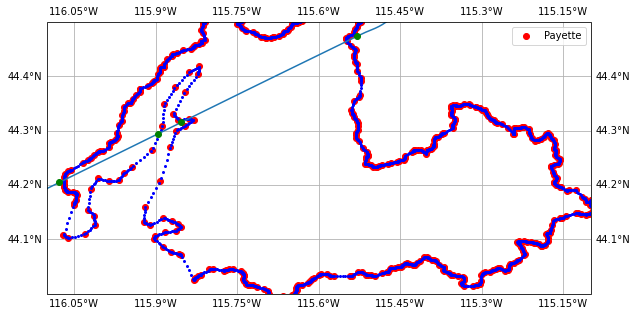

In [16]:
plt.figure(figsize=(18,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-115.6)) #central_latitude=44.25))
ax.set_extent([-116.1,-115.1,44,44.5])
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='50m', facecolor='none')
rivers = cfeature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='10m', facecolor='none', edgecolor='black')
ax.add_feature(states_provinces, edgecolor='grey', zorder=10)
ax.add_feature(rivers)
ax.gridlines(draw_labels=True)

p1, =plt.plot(df_payette_t['Lon'], df_payette_t['Lat'],'ro', label='Payette', transform=ccrs.PlateCarree())
plt.plot(stretched_p_lon, stretched_p_lat,'bo', markersize=2, label='Payette', transform=ccrs.PlateCarree())

plt.legend(handles=[p1])
plt.plot(flight_leg['Lons'],flight_leg['Lats'], transform=ccrs.PlateCarree())

small_dist=[]
f_i=[]
p_i=[]
for n in range(flight_leg['Lons'].shape[0]):
    for j in range (stretched_p_lon.shape[0]):
        distance_ta=get_distll(flight_leg['Lats'][n],flight_leg['Lons'][n], stretched_p_lat[j], stretched_p_lon[j])
        if distance_ta<.7:
            small_dist.append(distance_ta)
            #plt.plot(flight_leg['Lons'][n],flight_leg['Lats'][n],'ko',transform=ccrs.PlateCarree() )
            f_i.append(n)
            p_i.append(j)


fia=np.unique(np.asarray(f_i))
pia=np.unique(np.asarray(p_i))


fia_diff=[]
for n in range(fia.shape[0]):
    if n+1<fia.shape[0]:
        fia_diff.append(fia[n+1]-fia[n])
fia_diff= np.asarray(fia_diff)

big_diff_i=np.asarray(np.where(fia_diff!=1))

true_i=[]
true_i.append(fia[0])
#true_i.append(fia[big_diff_i[0,1]])
true_i.append(fia[big_diff_i[0,1]-50])
true_i.append(fia[big_diff_i[0,1]-70])
#true_i.append(fia[big_diff_i[0,1]+10])
#true_i.append(fia[big_diff_i[0,1]-90])
true_i.append(fia[-1])
true_i=np.asarray(true_i).astype(int)

for n in range(true_i.shape[0]):
    plt.plot(flight_leg['Lons'][true_i[n]],flight_leg['Lats'][true_i[n]],'go',transform=ccrs.PlateCarree() )
    
#plt.plot(flight_leg['Lons'][fia[40]],flight_leg['Lats'][fia[40]],'ro',transform=ccrs.PlateCarree() )
#plt.plot(flight_leg['Lons'][fia[20]],flight_leg['Lats'][fia[20]],'ro',transform=ccrs.PlateCarree() )

In [14]:
#the lat and lon of the the intersection between WKA and seeding aircraft
latw=44.065
lonw=-116.358

#calculating distance from start of flight leg to the intersection point (meters)
real_dist=get_distll(latw, lonw, flight_leg['Lats'][0], flight_leg['Lons'][0])*1000
print(real_dist)

#height of seeding aircraft when it intersected the cross section
seeding_height= 3962

85448.18643087064


In [15]:
height_initial= seeding_height
distance_initial=real_dist
height_wanted= seeding_height
distance_wanted=real_dist
t=1
xcoord=[]
ycoord=[]
time=[]
for n in range(100000):
    if distance_wanted< np.max(distance):
        [d,h,w]=put_it_all_together(distance_wanted, height_wanted,t)
        xcoord.append(d)
        ycoord.append(h)
        height_wanted=h
        distance_wanted=d
        if w==np.NaN:
            break

In [17]:
total_distance_traveled=np.abs(real_dist-xcoord[-1])
total_distance_traveled

masked_array(data=[nan],
             mask=[False],
       fill_value=1e+20)

In [18]:
iop_t[timeidx][3]

1

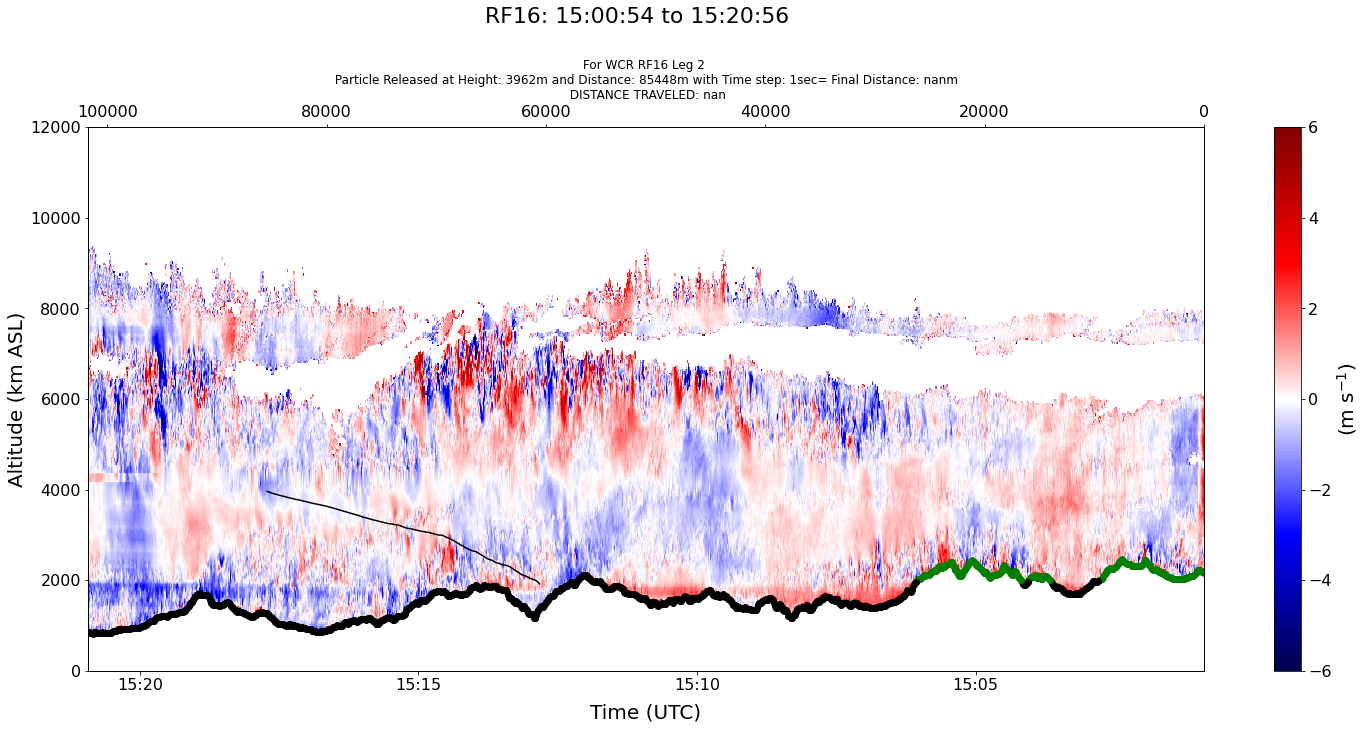

In [20]:
fig, ax = plt.subplots(figsize = (25, 10))

#plotting radar data
cm = ax.pcolormesh(time_subset_2d_wcr, gate_subset_wcr, w_a, vmin = -6, vmax = 6, cmap = 'seismic', rasterized = True)

cbar = plt.colorbar(cm, label = 'm s$^{-1}$)')
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(label='(m s$^{-1}$)',fontsize=20)

ax.set_ylim(0, 12000)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.tick_params(which='both',labelsize=16)

ax.set_ylabel('Altitude (km ASL)',fontsize=20)
ax.set_xlabel('Time (UTC)',fontsize=20, labelpad = 10)
plt.suptitle(rf + ': ' +  str(start_time)[11:19] + ' to ' + str(end_time)[11:19], fontsize = 22, x=.43, y=1.047)

if iop_t[timeidx][3]==1:
    ax.invert_xaxis()

#plotting terrain and distance
if iop_t[timeidx][3]==0:
    axx= ax.twinx()
    axx.set_ylim(0,12000)
    axx.axes.yaxis.set_visible(False)
    for n in range(flight_leg['topo'].shape[0]-1):
        if flight_leg['topo'].values[n]>1981:
            act_time=df_flight_time_subset[n]
            pt0=df_flight_time_subset[true_i[0]]
            pt1=df_flight_time_subset[true_i[1]]
            pt2=df_flight_time_subset[true_i[2]]
            pt3=df_flight_time_subset[true_i[-1]]
            if act_time>pt0 and act_time<pt1:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
            elif act_time>pt1 and act_time<pt2:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
            elif act_time>pt2 and act_time<pt3:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
            else:
                #axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        else:
            axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)

            
            
if iop_t[timeidx][3]==1:
    axx=ax.twiny()
    axx.set_ylim(0,12000)
    axx.axes.yaxis.set_visible(False)
    for n in range(flight_leg['topo'].shape[0]-1):
        if flight_leg['topo'].values[n]>1981:
            act_time=df_flight_time_subset[n]
            pt0=df_flight_time_subset[true_i[0]]
            pt1=df_flight_time_subset[true_i[1]]
            #pt2=df_flight_time_subset[true_i[2]]
            pt3=df_flight_time_subset[true_i[-1]]
            if act_time>pt0 and act_time<pt1:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
            elif act_time>pt1 and act_time<pt3:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
            #elif act_time>pt2 and act_time<pt3:
                #axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
            else:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
                #axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        else:
            axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)


axx.set_xlim(df_flight_time_subset[0], df_flight_time_subset[-1])
axx.xaxis.set_visible(False)

axx.set_xlabel('Distance (m)', fontsize=20)
#if west flight
if iop_t[timeidx][3]==1:
    axx.invert_xaxis()

#plotting trajectory
ax2=ax.twiny()
ax2.plot(xcoord, ycoord, color='black')
ax2.set_xlim(0,distance_wcr[-1])
ax2.tick_params(labelsize=16)

ax2.set_title('For WCR %s Leg %s \n Particle Released at Height: %dm and Distance: %dm with Time step: %dsec= Final Distance: %fm \n DISTANCE TRAVELED: %f'%(rf, leg ,height_initial, distance_initial, t, xcoord[-1], total_distance_traveled))
#if flight leg is west
if iop_t[timeidx][3]==1:
    ax2.invert_xaxis()

#plt.savefig('/glade/u/home/kaylee/Newest_traj/WCR/'+rf+'_Leg'+leg+'_S_height_'+str(height_initial)+'S_dist'+str(distance_initial)+'.pdf', format = 'pdf')
#plt.savefig('/glade/u/home/kaylee/Trajectories/WRF_HZwind/WCR/WCRRF'+rf+'Leg'+leg+'_redo.pdf', format = 'pdf')

In [1021]:
#if hole in cloud

In [21]:
#making the entire trajectory with w=0
#also saving teh true w values to know when the last w=nan occurs
height_initial= ycoord[-2]
distance_initial= xcoord[-2]
height_wanted= ycoord[-2]
distance_wanted= xcoord[-2]
t=1
xcoord_h1=[]
ycoord_h1=[]
time=[]
Nans=[]
for n in range(100000):
    if distance_wanted< np.max(distance):
        [loweri_wcr, upperi_wcr]=height_i(height_wanted, gate_subset_wcr)
        [loweri_wrf, upperi_wrf]=height_i(height_wanted, wrf_height_calcs)
        #[loweri_s, upperi_s]= height_i(height_wanted, height_v_sec_sounding_a)
        [closex_wcr, farx_wcr]=distance_i(distance_wanted, distance)
        [closex_wrf, farx_wrf]=distance_i(distance_wanted, wrf_distance)
        [time_at_point, before_t_i, after_t_i]=wcr_time_i(closex_wcr, farx_wcr, distance_wanted)
        angle_at_pt=value_at_point_1d(closex_wcr, farx_wcr, distance_wanted, distance, a_subset)
        u_at_pt=final_w_u_v(closex_wrf, farx_wrf, distance_wanted, loweri_wrf, upperi_wrf, height_wanted, wrf_u_a)
        v_at_pt=final_w_u_v(closex_wrf, farx_wrf, distance_wanted, loweri_wrf, upperi_wrf, height_wanted, wrf_v_a)

        w= 0
        T= final_v(time_at_point,before_t_i, after_t_i, distance_wanted, loweri_wcr, upperi_wcr, height_wanted,np.asarray(vt_interpolated))
        along_fl_wind= shifted_wind(u_at_pt, v_at_pt, angle_at_pt)

        [d, h]=next_position(distance_wanted,height_wanted,w,T,along_fl_wind,t)

        w_test= final_v(time_at_point,before_t_i, after_t_i, distance_wanted, loweri_wcr, upperi_wcr, height_wanted,w_a)
        
        Nans.append(w_test)

        xcoord_h1.append(d)
        ycoord_h1.append(h)
        height_wanted=h
        distance_wanted=d
        if w==np.NaN:
            break

In [23]:
#finding the index of where the first value of W occurs
ws=np.asarray(Nans)
w_nans=np.asarray(np.where(np.isnan(ws[:])==True))
first_value=[]
for n in range(w_nans.shape[1]-1):
    if n>0:
        diff=w_nans[0,n+1]-w_nans[0,n]
        if diff>1:
            first_value=w_nans[0,n]+1
            break

In [24]:
w_nans

array([], shape=(2, 0), dtype=int64)

In [25]:
first_value=57

In [99]:
#finding size of hole 1
x_size=np.abs(xcoord_h1[first_value]-xcoord_h1[0])
y_size= np.abs(ycoord_h1[first_value-1]-ycoord_h1[0])
print('X size= %d m, Y size= %d m'%(x_size, y_size))

X size= 919 m, Y size= 57 m


In [100]:
#computing the trajectory for after we have w!= np.Nan
height_initial= ycoord_h1[first_value]
distance_initial= xcoord_h1[first_value]
height_wanted= ycoord_h1[first_value]
distance_wanted= xcoord_h1[first_value]
t=1
xcoord_after_h1=[]
ycoord_after_h1=[]
time=[]
for n in range(100000):
    if distance_wanted< np.max(distance):
        [d,h,w]=put_it_all_together(distance_wanted, height_wanted,t)
        xcoord_after_h1.append(d)
        ycoord_after_h1.append(h)
        height_wanted=h
        distance_wanted=d
        if w==np.NaN:
            break

In [102]:
total_distance_traveled=np.abs(real_dist-xcoord_after_h1[-1])
total_distance_traveled

masked_array(data=[21282.210340265636],
             mask=[False],
       fill_value=1e+20)

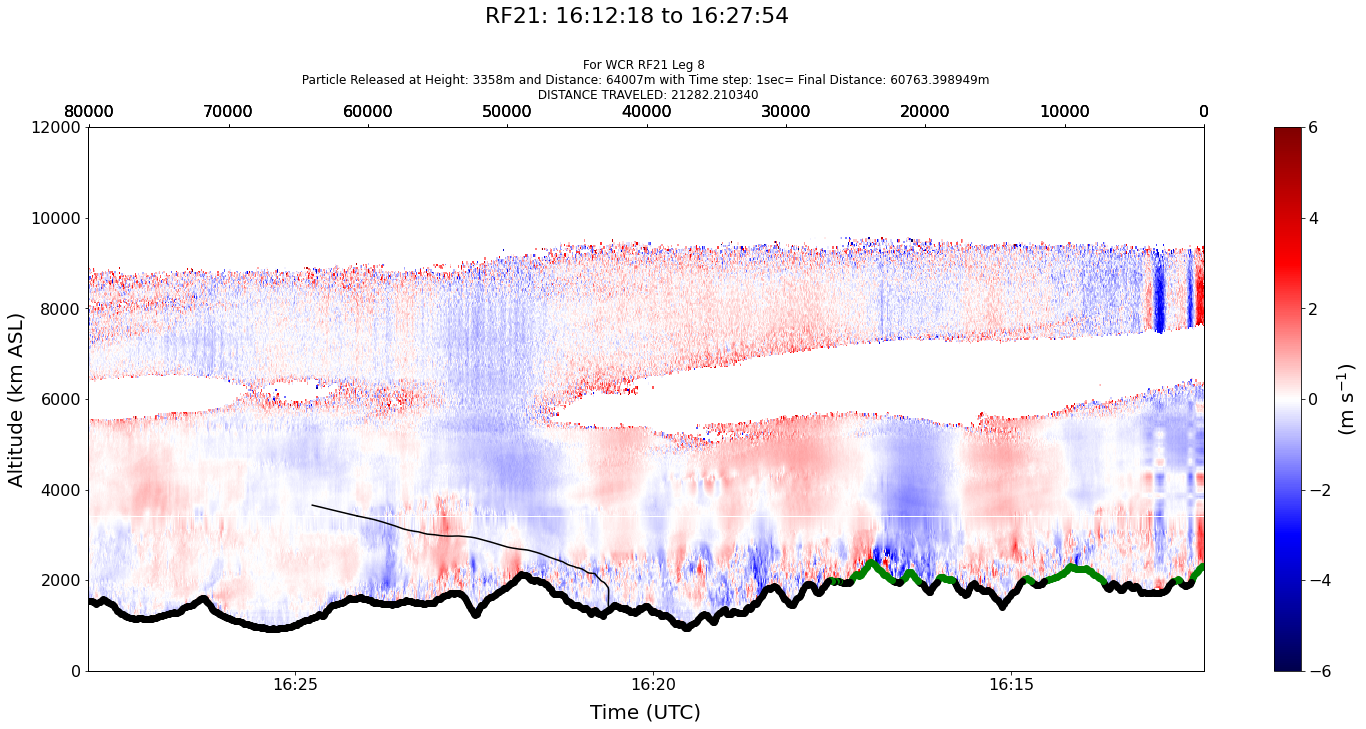

In [103]:
fig, ax = plt.subplots(figsize = (25, 10))

#plotting radar data
cm = ax.pcolormesh(time_subset_2d_wcr, gate_subset_wcr, w_a, vmin = -6, vmax = 6, cmap = 'seismic', rasterized = True)

cbar = plt.colorbar(cm, label = 'm s$^{-1}$)')
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(label='(m s$^{-1}$)',fontsize=20)

ax.set_ylim(0, 12000)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.tick_params(which='both',labelsize=16)

ax.set_ylabel('Altitude (km ASL)',fontsize=20)
ax.set_xlabel('Time (UTC)',fontsize=20, labelpad = 10)
plt.suptitle(rf + ': ' +  str(start_time)[11:19] + ' to ' + str(end_time)[11:19], fontsize = 22, x=.43, y=1.047)

#plotting terrain and distance
if iop_t[timeidx][3]==0:
    axx= ax.twinx()
    axx.set_ylim(0,12000)
    axx.axes.yaxis.set_visible(False)
    for n in range(flight_leg['topo'].shape[0]-1):
        if flight_leg['topo'].values[n]>1981:
            act_time=df_flight_time_subset[n]
            pt0=df_flight_time_subset[true_i[0]]
            pt1=df_flight_time_subset[true_i[1]]
            #pt2=df_flight_time_subset[true_i[2]]
            pt3=df_flight_time_subset[true_i[-1]]
            if act_time>pt0 and act_time<pt1:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
            elif act_time>pt1 and act_time<pt3:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
            #elif act_time>pt2 and act_time<pt3:
                #axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
            else:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
                #axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        else:
            axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)

            
            
if iop_t[timeidx][3]==1:
    axx=ax.twiny()
    axx.set_ylim(0,12000)
    axx.axes.yaxis.set_visible(False)
    for n in range(flight_leg['topo'].shape[0]-1):
        if flight_leg['topo'].values[n]>1981:
            act_time=df_flight_time_subset[n]
            pt0=df_flight_time_subset[true_i[0]]
            pt1=df_flight_time_subset[true_i[1]]
            #pt2=df_flight_time_subset[true_i[2]]
            pt3=df_flight_time_subset[true_i[-1]]
            if act_time>pt0 and act_time<pt1:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
            elif act_time>pt1 and act_time<pt3:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
            #elif act_time>pt2 and act_time<pt3:
                #axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
            else:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
                #axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        else:
            axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)

            
            

axx.set_xlim(df_flight_time_subset[0], df_flight_time_subset[-1])
axx.xaxis.set_visible(False)

axx.set_xlabel('Distance (m)', fontsize=20)
#if west flight
if iop_t[timeidx][3]==1:
    axx.invert_xaxis()
    ax.invert_xaxis()

#plotting trajectory
ax2=ax.twiny()
ax2.plot(xcoord, ycoord, color='black')
ax2.set_xlim(0,distance_wcr[-1])
ax2.tick_params(labelsize=16)

ax2.set_title('For WCR %s Leg %s \n Particle Released at Height: %dm and Distance: %dm with Time step: %dsec= Final Distance: %fm \n DISTANCE TRAVELED: %f'%(rf, leg ,height_initial, real_dist, t, xcoord[-1], total_distance_traveled))
#if flight leg is west
if iop_t[timeidx][3]==1:
    ax2.invert_xaxis()
    
#axv=ax.twiny()
#axv.plot(xcoord3, ycoord3, color='k')
#axv.set_xlim(0,np.max(distance))
#axv.tick_params(which='both',labelsize=16)
#if iop_t[timeidx][3]==1:
    #axv.invert_xaxis()
    
ax3=ax.twiny()
ax3.plot(np.asarray(xcoord_h1)[0:first_value], np.asarray(ycoord_h1)[0:first_value], color='k')
ax3.set_xlim(0,np.max(distance_wcr))
ax3.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax3.invert_xaxis()
    
    
ax4=ax.twiny()
ax4.plot(xcoord_after_h1, ycoord_after_h1, color='k')
ax4.set_xlim(0,np.max(distance_wcr))
ax4.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax4.invert_xaxis()

#plt.savefig('/glade/u/home/kaylee/Newest_traj/WCR/'+rf+'_Leg'+leg+'_S_height_'+str(height_initial)+'S_dist'+str(distance_initial)+'.pdf', format = 'pdf')
plt.savefig('/glade/u/home/kaylee/Trajectories/WRF_HZwind/WCR/WCRRF'+rf+'_Leg'+leg+'_redo.pdf', format = 'pdf')

In [ ]:
#second hole

In [675]:
#making the entire trajectory with w=0
#also saving teh true w values to know when the last w=nan occurs
height_initial= ycoord_after_h1[-2]
distance_initial= xcoord_after_h1[-2]
height_wanted= ycoord_after_h1[-2]
distance_wanted= xcoord_after_h1[-2]
t=1
xcoord_h2=[]
ycoord_h2=[]
time=[]
Nans=[]
for n in range(1000000):
    if distance_wanted< np.max(distance):
        [loweri_wcr, upperi_wcr]=height_i(height_wanted, gate_subset_wcr)
        [loweri_wrf, upperi_wrf]=height_i(height_wanted, wrf_height_calcs)
        #[loweri_s, upperi_s]= height_i(height_wanted, height_v_sec_sounding_a)
        [closex_wcr, farx_wcr]=distance_i(distance_wanted, distance)
        [closex_wrf, farx_wrf]=distance_i(distance_wanted, wrf_distance)
        [time_at_point, before_t_i, after_t_i]=wcr_time_i(closex_wcr, farx_wcr, distance_wanted)
        angle_at_pt=value_at_point_1d(closex_wcr, farx_wcr, distance_wanted, distance, a_subset)
        u_at_pt=final_w_u_v(closex_wrf, farx_wrf, distance_wanted, loweri_wrf, upperi_wrf, height_wanted, wrf_u_a)
        v_at_pt=final_w_u_v(closex_wrf, farx_wrf, distance_wanted, loweri_wrf, upperi_wrf, height_wanted, wrf_v_a)

        w= 0
        T= final_v(time_at_point,before_t_i, after_t_i, distance_wanted, loweri_wcr, upperi_wcr, height_wanted,np.asarray(vt_interpolated))
        along_fl_wind= shifted_wind(u_at_pt, v_at_pt, angle_at_pt)

        [d, h]=next_position(distance_wanted,height_wanted,w,T,along_fl_wind,t)

        w_test= final_v(time_at_point,before_t_i, after_t_i, distance_wanted, loweri_wcr, upperi_wcr, height_wanted,w_a)
        
        Nans.append(w_test)

        xcoord_h2.append(d)
        ycoord_h2.append(h)
        height_wanted=h
        distance_wanted=d
        if w==np.NaN:
            break

In [676]:
#finding the index of where the first value of W occurs
ws=np.asarray(Nans)
w_nans=np.asarray(np.where(np.isnan(ws[:])==True))
for n in range(w_nans.shape[1]-1):
    if n>0:
        diff=w_nans[0,n+1]-w_nans[0,n]
        if diff>1:
            first_value=w_nans[0,n]+1
            break

In [677]:
w_nans

array([[  0, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557,
        558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570,
        571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583,
        584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596,
        597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609,
        610],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]])

In [678]:
first_value=1

In [679]:
#finding size of hole 1
x_size=np.abs(xcoord_h2[first_value]-xcoord_h2[0])
y_size= np.abs(ycoord_h2[first_value]-ycoord_h2[0])
print('X size= %d m, Y size= %d m'%(x_size, y_size))

X size= 10 m, Y size= 0 m


In [680]:
#computing the trajectory for after we have w!= np.Nan
height_initial= ycoord_h2[first_value]
distance_initial= xcoord_h2[first_value]
height_wanted= ycoord_h2[first_value]
distance_wanted= xcoord_h2[first_value]
t=1
xcoord_after_h2=[]
ycoord_after_h2=[]
time=[]
for n in range(10000000):
    if distance_wanted< np.max(distance):
        [d,h,w]=put_it_all_together(distance_wanted, height_wanted,t)
        xcoord_after_h2.append(d)
        ycoord_after_h2.append(h)
        height_wanted=h
        distance_wanted=d
        if w==np.NaN:
            break

ValueError: zero-size array to reduction operation minimum which has no identity

In [681]:
total_distance_traveled=np.abs(real_dist-xcoord_after_h2[-2])
total_distance_traveled

masked_array(data=[1499.3821662094488],
             mask=[False],
       fill_value=1e+20)

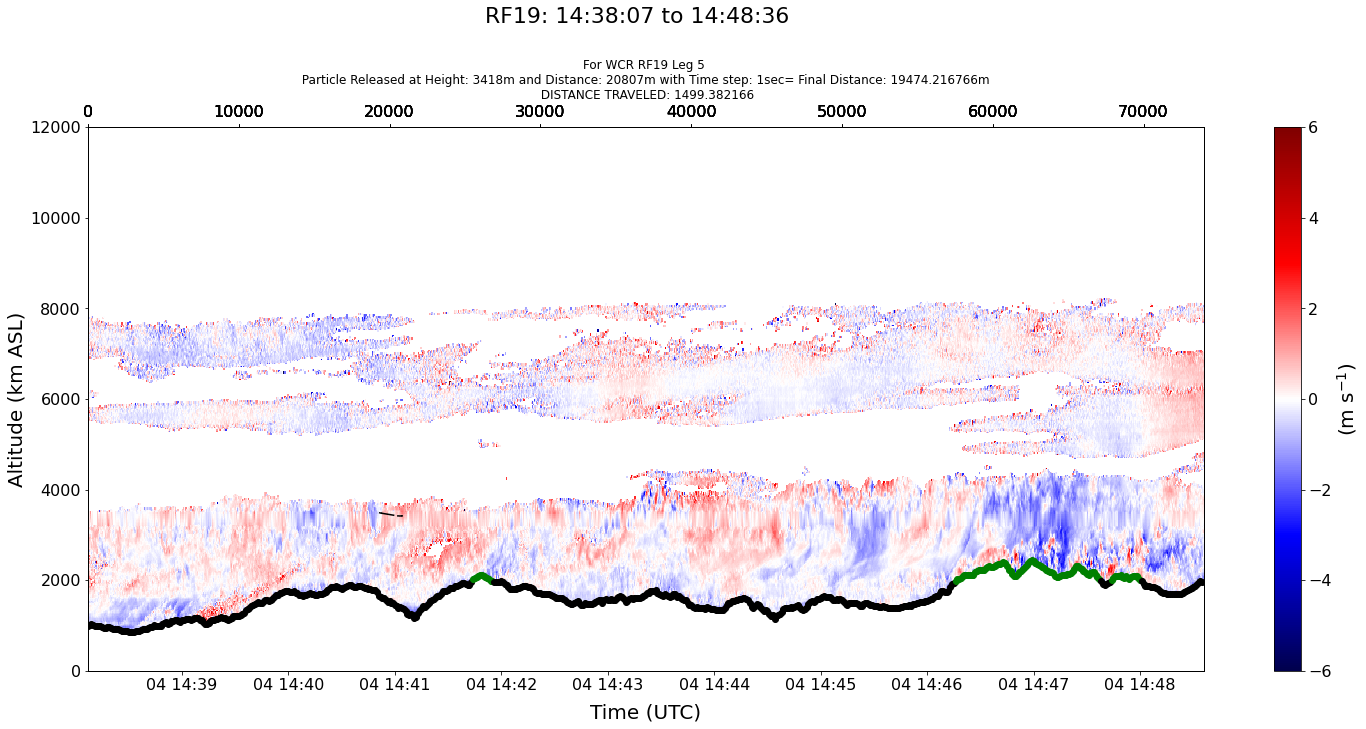

In [682]:
fig, ax = plt.subplots(figsize = (25, 10))

#plotting radar data
cm = ax.pcolormesh(time_subset_2d_wcr, gate_subset_wcr, w_a, vmin = -6, vmax = 6, cmap = 'seismic', rasterized = True)

cbar = plt.colorbar(cm, label = 'm s$^{-1}$)')
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(label='(m s$^{-1}$)',fontsize=20)

ax.set_ylim(0, 12000)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.tick_params(which='both',labelsize=16)

ax.set_ylabel('Altitude (km ASL)',fontsize=20)
ax.set_xlabel('Time (UTC)',fontsize=20, labelpad = 10)
plt.suptitle(rf + ': ' +  str(start_time)[11:19] + ' to ' + str(end_time)[11:19], fontsize = 22, x=.43, y=1.047)

if iop_t[timeidx][3]==1:
    ax.invert_xaxis()

#plotting terrain and distance
if iop_t[timeidx][3]==0:
    axx= ax.twinx()
    axx.set_ylim(0,12000)
    axx.axes.yaxis.set_visible(False)
    for n in range(flight_leg['topo'].shape[0]-1):
        if flight_leg['topo'].values[n]>1981:
            act_time=df_flight_time_subset[n]
            pt0=df_flight_time_subset[true_i[0]]
            pt1=df_flight_time_subset[true_i[1]]
            #pt2=df_flight_time_subset[true_i[2]]
            pt3=df_flight_time_subset[true_i[-1]]
            if act_time>pt0 and act_time<pt1:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
            elif act_time>pt1 and act_time<pt3:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
            #elif act_time>pt2 and act_time<pt3:
                #axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
            else:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
                #axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        else:
            axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)

            
            
if iop_t[timeidx][3]==1:
    axx=ax.twiny()
    axx.set_ylim(0,12000)
    axx.axes.yaxis.set_visible(False)
    for n in range(flight_leg['topo'].shape[0]-1):
        if flight_leg['topo'].values[n]>1981:
            act_time=df_flight_time_subset[n]
            pt0=df_flight_time_subset[true_i[0]]
            pt1=df_flight_time_subset[true_i[1]]
            #pt2=df_flight_time_subset[true_i[2]]
            pt3=df_flight_time_subset[true_i[-1]]
            if act_time>pt0 and act_time<pt1:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
            elif act_time>pt1 and act_time<pt3:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
            #elif act_time>pt2 and act_time<pt3:
                #axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
            else:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
                #axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        else:
            axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)

axx.set_xlim(df_flight_time_subset[0], df_flight_time_subset[-1])
axx.xaxis.set_visible(False)

axx.set_xlabel('Distance (m)', fontsize=20)
#if west flight
if iop_t[timeidx][3]==1:
    axx.invert_xaxis()

#plotting trajectory
ax2=ax.twiny()
ax2.plot(xcoord, ycoord, color='black')
ax2.set_xlim(0,distance_wcr[-1])
ax2.tick_params(labelsize=16)

ax2.set_title('For WCR %s Leg %s \n Particle Released at Height: %dm and Distance: %dm with Time step: %dsec= Final Distance: %fm \n DISTANCE TRAVELED: %f'%(rf, leg ,height_initial, distance_initial, t, xcoord[-1], total_distance_traveled))
#if flight leg is west
if iop_t[timeidx][3]==1:
    ax2.invert_xaxis()
    
#axv=ax.twiny()
#axv.plot(xcoord3, ycoord3, color='k')
#axv.set_xlim(0,np.max(distance))
#axv.tick_params(which='both',labelsize=16)
#if iop_t[timeidx][3]==1:
    #axv.invert_xaxis()
    
    
ax3=ax.twiny()
ax3.plot(np.asarray(xcoord_h1)[0:103,0], np.asarray(ycoord_h1)[0:103,0], color='k')
ax3.set_xlim(0,np.max(distance_wcr))
ax3.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax3.invert_xaxis()
    
    
ax4=ax.twiny()
ax4.plot(xcoord_after_h1, ycoord_after_h1, color='k')
ax4.set_xlim(0,np.max(distance_wcr))
ax4.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax4.invert_xaxis()
    
ax5=ax.twiny()
ax5.plot(np.asarray(xcoord_h2)[0:first_value,0], np.asarray(ycoord_h2)[0:first_value,0], color='k')
ax5.set_xlim(0,np.max(distance_wcr))
ax5.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax5.invert_xaxis()
    
ax6=ax.twiny()
ax6.plot(xcoord_after_h2, ycoord_after_h2, color='k')
ax6.set_xlim(0,np.max(distance_wcr))
ax6.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax6.invert_xaxis()

#plt.savefig('/glade/u/home/kaylee/Newest_traj/WCR/'+rf+'_Leg'+leg+'_S_height_'+str(height_initial)+'S_dist'+str(distance_initial)+'.pdf', format = 'pdf')
plt.savefig('/glade/u/home/kaylee/Trajectories/WRF_HZwind/WCR/WCRRF'+rf+'_Leg'+leg+'.pdf', format = 'pdf')

In [683]:
#third hole

In [684]:
#making the entire trajectory with w=0
#also saving teh true w values to know when the last w=nan occurs
height_initial= ycoord_after_h2[-2]
distance_initial= xcoord_after_h2[-2]
height_wanted= ycoord_after_h2[-2]
distance_wanted= xcoord_after_h2[-2]
t=1
xcoord_h3=[]
ycoord_h3=[]
time=[]
Nans=[]
for n in range(100000):
    if distance_wanted< np.max(distance):
        [loweri_wcr, upperi_wcr]=height_i(height_wanted, gate_subset_wcr)
        [loweri_wrf, upperi_wrf]=height_i(height_wanted, wrf_height_calcs)
        #[loweri_s, upperi_s]= height_i(height_wanted, height_v_sec_sounding_a)
        [closex_wcr, farx_wcr]=distance_i(distance_wanted, distance)
        [closex_wrf, farx_wrf]=distance_i(distance_wanted, wrf_distance)
        [time_at_point, before_t_i, after_t_i]=wcr_time_i(closex_wcr, farx_wcr, distance_wanted)
        angle_at_pt=value_at_point_1d(closex_wcr, farx_wcr, distance_wanted, distance, a_subset)
        u_at_pt=final_w_u_v(closex_wrf, farx_wrf, distance_wanted, loweri_wrf, upperi_wrf, height_wanted, wrf_u_a)
        v_at_pt=final_w_u_v(closex_wrf, farx_wrf, distance_wanted, loweri_wrf, upperi_wrf, height_wanted, wrf_v_a)

        w= 0
        T= final_v(time_at_point,before_t_i, after_t_i, distance_wanted, loweri_wcr, upperi_wcr, height_wanted,np.asarray(vt_interpolated))
        along_fl_wind= shifted_wind(u_at_pt, v_at_pt, angle_at_pt)

        [d, h]=next_position(distance_wanted,height_wanted,w,T,along_fl_wind,t)

        w_test= final_v(time_at_point,before_t_i, after_t_i, distance_wanted, loweri_wcr, upperi_wcr, height_wanted,w_a)
        
        Nans.append(w_test)

        xcoord_h1.append(d)
        ycoord_h1.append(h)
        height_wanted=h
        distance_wanted=d
        if w==np.NaN:
            break

In [685]:
#finding the index of where the first value of W occurs
ws=np.asarray(Nans)
w_nans=np.asarray(np.where(np.isnan(ws[:])==True))
for n in range(w_nans.shape[1]-1):
    if n>0:
        diff=w_nans[0,n+1]-w_nans[0,n]
        if diff>1:
            first_value=w_nans[0,n]+1
            break

In [686]:
w_nans

array([[  0, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558,
        559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571,
        572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584,
        585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597,
        598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [691]:
first_value=1
first_value

1

In [692]:
#finding size of hole 1
x_size=np.abs(xcoord_h3[first_value]-xcoord_h3[0])
y_size= np.abs(ycoord_h3[first_value]-ycoord_h3[0])
print('X size= %d m, Y size= %d m'%(x_size, y_size))

IndexError: list index out of range

In [173]:
#computing the trajectory for after we have w!= np.Nan
height_initial= ycoord_h3[first_value]
distance_initial= xcoord_h3[first_value]
height_wanted= ycoord_h3[first_value]
distance_wanted= xcoord_h3[first_value]
t=1
xcoord_after_h3=[]
ycoord_after_h3=[]
time=[]
for n in range(100000):
    if distance_wanted< np.max(distance):
        [d,h,w]=put_it_all_together(distance_wanted, height_wanted,t)
        xcoord_after_h2.append(d)
        ycoord_after_h2.append(h)
        height_wanted=h
        distance_wanted=d
        if w==np.NaN:
            break

IndexError: list index out of range

In [220]:
total_distance_traveled=np.abs(real_dist-xcoord_after_h3[-1])

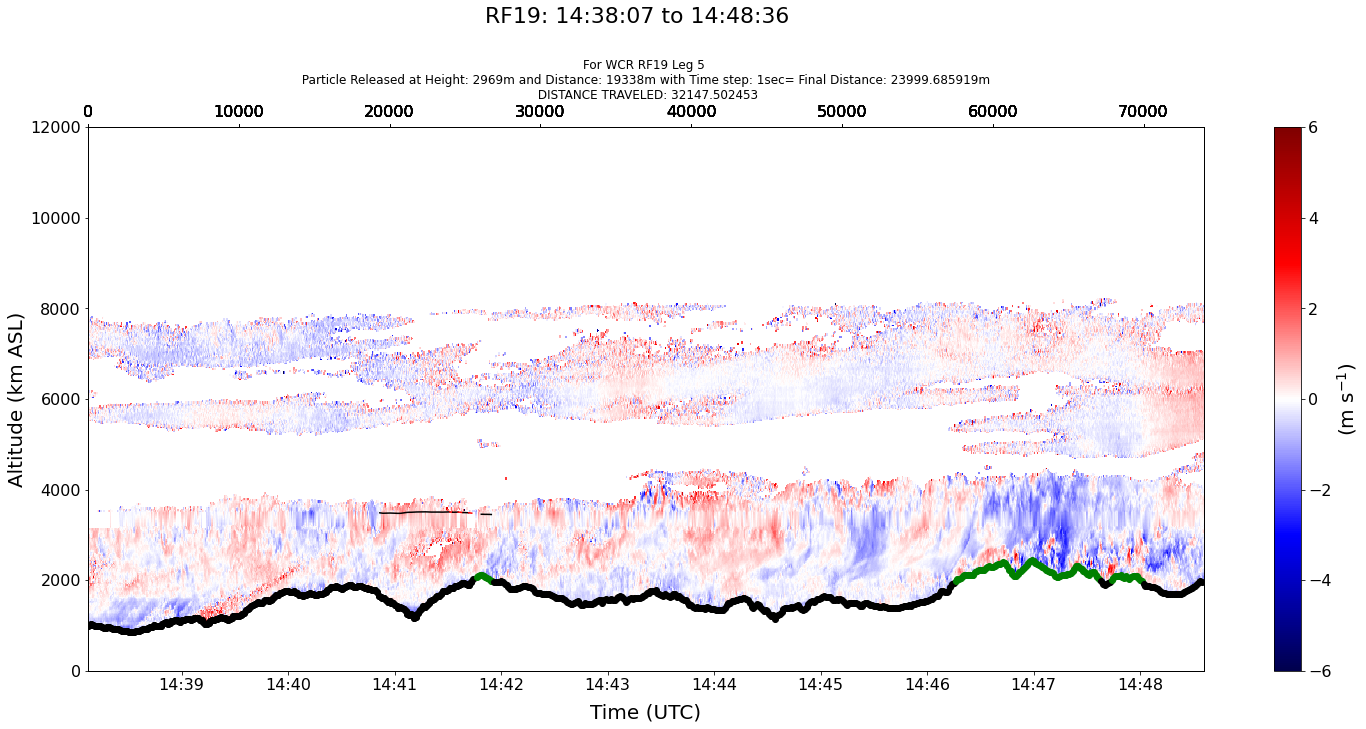

In [244]:
fig, ax = plt.subplots(figsize = (25, 10))

#plotting radar data
cm = ax.pcolormesh(time_subset_2d_wcr, gate_subset_wcr, w_a, vmin = -6, vmax = 6, cmap = 'seismic', rasterized = True)

cbar = plt.colorbar(cm, label = 'm s$^{-1}$)')
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(label='(m s$^{-1}$)',fontsize=20)

ax.set_ylim(0, 12000)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.tick_params(which='both',labelsize=16)

ax.set_ylabel('Altitude (km ASL)',fontsize=20)
ax.set_xlabel('Time (UTC)',fontsize=20, labelpad = 10)
plt.suptitle(rf + ': ' +  str(start_time)[11:19] + ' to ' + str(end_time)[11:19], fontsize = 22, x=.43, y=1.047)

if iop_t[timeidx][3]==1:
    ax.invert_xaxis()

#plotting terrain and distance
if iop_t[timeidx][3]==0:
    axy=ax.twiny()
    for n in range(flight_leg['topo'].shape[0]-1):
        if flight_leg['topo'].values[n]<1981:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        #if flight_leg['topo'].values[n]>=1981:
            #axy.plot(distance[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]>df_flight_time_subset[true_i[0]] and df_flight_time_subset[n]<df_flight_time_subset[true_i[1]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]>df_flight_time_subset[true_i[-1]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        #if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]>df_flight_time_subset[fia[25]] and df_flight_time_subset[n]<df_flight_time_subset[true_i[-1]]:
            #axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        #if flight_leg['topo'].values[n]>=1981 and distance[n]>distance[true_i[3]]:
            #axy.plot(distance[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        #if distance[n]>distance[true_i[-1]]:
           # axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        if df_flight_time_subset[n]<df_flight_time_subset[true_i[0]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        #if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]>df_flight_time_subset[true_i[1]] and df_flight_time_subset[n]<df_flight_time_subset[fia[25]]:
            #axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
            
if iop_t[timeidx][3]==1:
    axy=ax.twiny()
    for n in range(flight_leg['topo'].shape[0]-1):
        if flight_leg['topo'].values[n]<1981:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        #if flight_leg['topo'].values[n]>=1981:
            #axy.plot(distance[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]<df_flight_time_subset[true_i[0]]:# and df_flight_time_subset[n]<df_flight_time_subset[true_i[1]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]>df_flight_time_subset[true_i[1]] and df_flight_time_subset[n]<df_flight_time_subset[true_i[-1]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
       # if flight_leg['topo'].values[n]>=1981 and distance[n]>distance[fia[20]] and distance[n]<distance[true_i[-1]]:
            #axy.plot(distance[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        #if df_flight_time_subset[n]<df_flight_time_subset[true_i[0]]:
            #axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        if df_flight_time_subset[n]>df_flight_time_subset[true_i[-1]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)

axy.set_xlim(df_flight_time_subset[0], df_flight_time_subset[-1])
axy.xaxis.set_visible(False)

axy.set_xlabel('Distance (m)', fontsize=20)
#if west flight
if iop_t[timeidx][3]==1:
    axy.invert_xaxis()

#plotting trajectory
ax2=ax.twiny()
ax2.plot(xcoord, ycoord, color='black')
ax2.set_xlim(0,distance_wcr[-1])
ax2.tick_params(labelsize=16)

ax2.set_title('For WCR %s Leg %s \n Particle Released at Height: %dm and Distance: %dm with Time step: %dsec= Final Distance: %fm \n DISTANCE TRAVELED: %f'%(rf, leg ,height_initial, real_dist, t, xcoord[-1], total_distance_traveled))
#if flight leg is west
if iop_t[timeidx][3]==1:
    ax2.invert_xaxis()

    
#axv=ax.twiny()
#axv.plot(xcoord3, ycoord3, color='k')
#axv.set_xlim(0,np.max(distance))
#axv.tick_params(which='both',labelsize=16)
#if iop_t[timeidx][3]==1:
    #axv.invert_xaxis()
    
ax3=ax.twiny()
ax3.plot(np.asarray(xcoord_h1)[0:12,0], np.asarray(ycoord_h1)[0:12,0], color='r')
ax3.set_xlim(0,np.max(distance_wcr))
ax3.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax3.invert_xaxis()
    
    
ax4=ax.twiny()
ax4.plot(xcoord_after_h1, ycoord_after_h1, color='k')
ax4.set_xlim(0,np.max(distance_wcr))
ax4.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax4.invert_xaxis()
    
ax5=ax.twiny()
ax5.plot(np.asarray(xcoord_h2)[0:21,0], np.asarray(ycoord_h2)[0:21,0], color='r')
ax5.set_xlim(0,np.max(distance_wcr))
ax5.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax5.invert_xaxis()
    
ax6=ax.twiny()
ax6.plot(xcoord_after_h2, ycoord_after_h2, color='k')
ax6.set_xlim(0,np.max(distance_wcr))
ax6.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax6.invert_xaxis()

ax7=ax.twiny()
ax7.plot(np.asarray(xcoord_h3)[0:first_value,0], np.asarray(ycoord_h3)[0:first_value,0], color='r')
ax7.set_xlim(0,np.max(distance_wcr))
ax7.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax7.invert_xaxis()
    
ax8=ax.twiny()
ax8.plot(xcoord_after_h3, ycoord_after_h3, color='k')
ax8.set_xlim(0,np.max(distance_wcr))
ax8.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax8.invert_xaxis()
#plt.savefig('/glade/u/home/kaylee/Newest_traj/WCR/'+rf+'_Leg'+leg+'_S_height_'+str(height_initial)+'S_dist'+str(distance_initial)+'.pdf', format = 'pdf')

In [454]:
#forth hole

In [222]:
#making the entire trajectory with w=0
#also saving teh true w values to know when the last w=nan occurs
height_initial= ycoord_after_h3[-2]
distance_initial= xcoord_after_h3[-2]
height_wanted= ycoord_after_h3[-2]
distance_wanted= xcoord_after_h3[-2]
t=1
xcoord_h4=[]
ycoord_h4=[]
time=[]
Nans=[]
for n in range(100000):
    if distance_wanted< np.max(distance):
        [loweri_wcr, upperi_wcr]=height_i(height_wanted, gate_subset_wcr)
        [loweri_s, upperi_s]= height_i(height_wanted, height_v_sec_sounding_a)
        [before_i, after_i]=distance_i(distance_wanted)
        [time_at_point, before_t_i, after_t_i]=wcr_time_i(before_i, after_i, distance_wanted)
        angle_at_pt=value_at_point_1d(before_i, after_i, distance_wanted, distance, a_subset)
        u_at_pt=value_at_point_1d(loweri_s, upperi_s, height_wanted, height_sounding_a, u_sounding_a)
        v_at_pt=value_at_point_1d(loweri_s, upperi_s, height_wanted, height_sounding_a, v_sounding_a)
        w= 0
        T= final_v(time_at_point,before_t_i, after_t_i, distance_wanted, loweri_wcr, upperi_wcr, height_wanted,np.asarray(vt_interpolated))
        along_fl_wind= shifted_wind(u_at_pt, v_at_pt, angle_at_pt)
    
        [d, h]=next_position(distance_wanted,height_wanted,w,T,along_fl_wind,t)
        
        w_test= final_v(time_at_point,before_t_i, after_t_i, distance_wanted, loweri_wcr, upperi_wcr, height_wanted,w_a)
        
        Nans.append(w_test)

        xcoord_h4.append(d)
        ycoord_h4.append(h)
        height_wanted=h
        distance_wanted=d
        if w==np.NaN:
            break

ValueError: zero-size array to reduction operation minimum which has no identity

In [223]:
#finding the index of where the first value of W occurs
ws=np.asarray(Nans)
w_nans=np.asarray(np.where(np.isnan(ws[:])==True))
for n in range(w_nans.shape[1]-1):
    if n>0:
        diff=w_nans[0,n+1]-w_nans[0,n]
        if diff>1:
            first_value=w_nans[0,n]+1
            break

In [224]:
first_value

15

In [225]:
#finding size of hole 1
x_size=np.abs(xcoord_h4[first_value]-xcoord_h4[0])
y_size= np.abs(ycoord_h4[first_value]-ycoord_h4[0])
print('X size= %d m, Y size= %d m'%(x_size, y_size))

X size= 211 m, Y size= 8 m


In [226]:
#computing the trajectory for after we have w!= np.Nan
height_initial= ycoord_h4[first_value]
distance_initial= xcoord_h4[first_value]
height_wanted= ycoord_h4[first_value]
distance_wanted= xcoord_h4[first_value]
t=1
xcoord_after_h4=[]
ycoord_after_h4=[]
time=[]
for n in range(100000):
    if distance_wanted< np.max(distance):
        [loweri_wcr, upperi_wcr]=height_i(height_wanted, gate_subset_wcr)
        [loweri_s, upperi_s]= height_i(height_wanted, height_v_sec_sounding_a)
        [before_i, after_i]=distance_i(distance_wanted)
        [time_at_point, before_t_i, after_t_i]=wcr_time_i(before_i, after_i, distance_wanted)
        angle_at_pt=value_at_point_1d(before_i, after_i, distance_wanted, distance, a_subset)
        u_at_pt=value_at_point_1d(loweri_s, upperi_s, height_wanted, height_sounding_a, u_sounding_a)
        v_at_pt=value_at_point_1d(loweri_s, upperi_s, height_wanted, height_sounding_a, v_sounding_a)
        w=final_v(time_at_point,before_t_i, after_t_i, distance_wanted, loweri_wcr, upperi_wcr, height_wanted,w_a)
        T= final_v(time_at_point,before_t_i, after_t_i, distance_wanted, loweri_wcr, upperi_wcr, height_wanted,np.asarray(vt_interpolated))
        along_fl_wind= shifted_wind(u_at_pt, v_at_pt, angle_at_pt)
    
        [d, h]=next_position(distance_wanted,height_wanted,w,T,along_fl_wind,t)
        
        xcoord_after_h4.append(d)
        ycoord_after_h4.append(h)
        height_wanted=h
        distance_wanted=d
        if w==np.NaN:
            break

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
total_distance_traveled=np.abs(real_dist-xcoord_after_h4[-1])

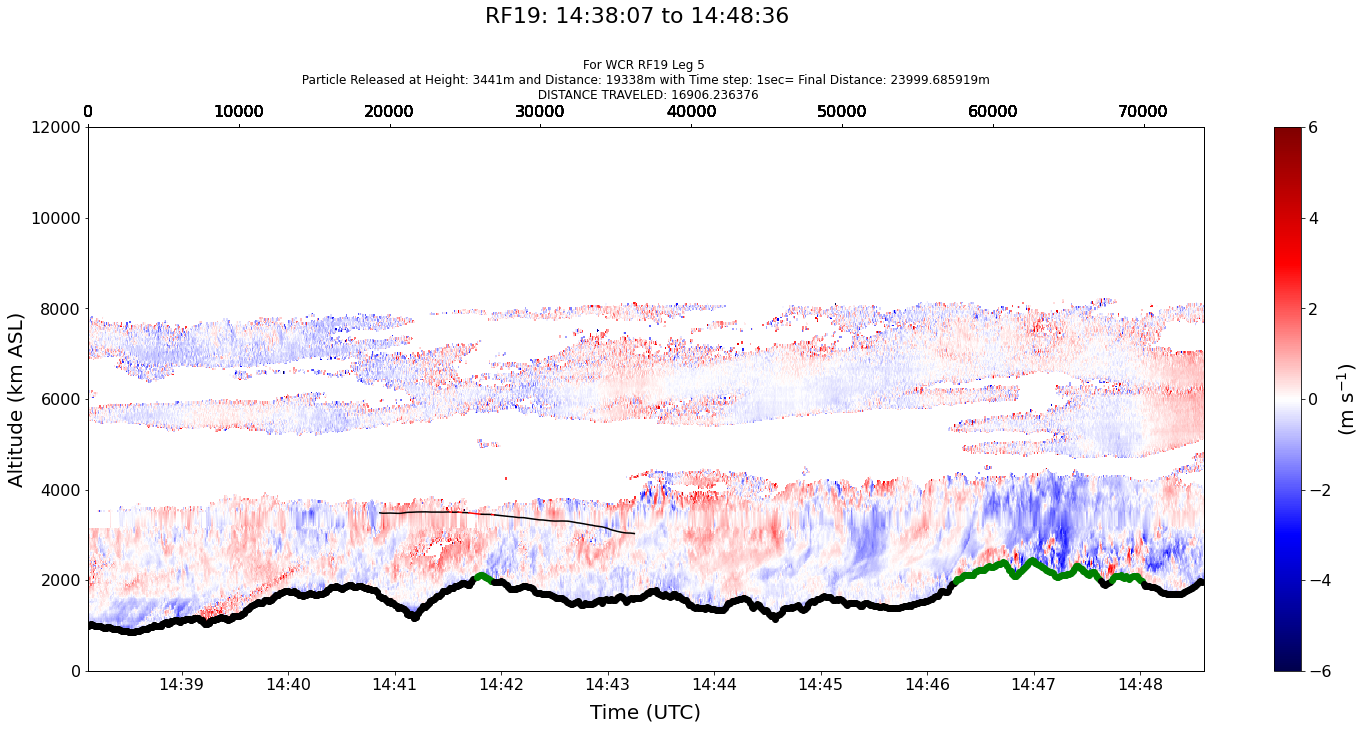

In [228]:
fig, ax = plt.subplots(figsize = (25, 10))

#plotting radar data
cm = ax.pcolormesh(time_subset_2d_wcr, gate_subset_wcr, w_a, vmin = -6, vmax = 6, cmap = 'seismic', rasterized = True)

cbar = plt.colorbar(cm, label = 'm s$^{-1}$)')
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(label='(m s$^{-1}$)',fontsize=20)

ax.set_ylim(0, 12000)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.tick_params(which='both',labelsize=16)

ax.set_ylabel('Altitude (km ASL)',fontsize=20)
ax.set_xlabel('Time (UTC)',fontsize=20, labelpad = 10)
plt.suptitle(rf + ': ' +  str(start_time)[11:19] + ' to ' + str(end_time)[11:19], fontsize = 22, x=.43, y=1.047)

if iop_t[timeidx][3]==1:
    ax.invert_xaxis()

#plotting terrain and distance
if iop_t[timeidx][3]==0:
    axy=ax.twiny()
    for n in range(flight_leg['topo'].shape[0]-1):
        if flight_leg['topo'].values[n]<1981:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        #if flight_leg['topo'].values[n]>=1981:
            #axy.plot(distance[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]>df_flight_time_subset[true_i[0]] and df_flight_time_subset[n]<df_flight_time_subset[true_i[1]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]>df_flight_time_subset[true_i[-1]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        #if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]>df_flight_time_subset[fia[25]] and df_flight_time_subset[n]<df_flight_time_subset[true_i[-1]]:
            #axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        #if flight_leg['topo'].values[n]>=1981 and distance[n]>distance[true_i[3]]:
            #axy.plot(distance[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        #if distance[n]>distance[true_i[-1]]:
           # axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        if df_flight_time_subset[n]<df_flight_time_subset[true_i[0]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        #if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]>df_flight_time_subset[true_i[1]] and df_flight_time_subset[n]<df_flight_time_subset[fia[25]]:
            #axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
            
if iop_t[timeidx][3]==1:
    axy=ax.twiny()
    for n in range(flight_leg['topo'].shape[0]-1):
        if flight_leg['topo'].values[n]<1981:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        #if flight_leg['topo'].values[n]>=1981:
            #axy.plot(distance[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]>df_flight_time_subset[true_i[0]] and df_flight_time_subset[n]<df_flight_time_subset[true_i[1]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]>df_flight_time_subset[fia[21]] and df_flight_time_subset[n]<df_flight_time_subset[true_i[-1]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
       # if flight_leg['topo'].values[n]>=1981 and distance[n]>distance[fia[20]] and distance[n]<distance[true_i[-1]]:
            #axy.plot(distance[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        if df_flight_time_subset[n]<df_flight_time_subset[true_i[0]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        if df_flight_time_subset[n]>df_flight_time_subset[true_i[-1]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
            

axy.set_xlim(df_flight_time_subset[0], df_flight_time_subset[-1])
axy.xaxis.set_visible(False)

axy.set_xlabel('Distance (m)', fontsize=20)
#if west flight
if iop_t[timeidx][3]==1:
    axy.invert_xaxis()

#plotting trajectory
ax2=ax.twiny()
ax2.plot(xcoord, ycoord, color='black')
ax2.set_xlim(0,distance_wcr[-1])
ax2.tick_params(labelsize=16)

ax2.set_title('For WCR %s Leg %s \n Particle Released at Height: %dm and Distance: %dm with Time step: %dsec= Final Distance: %fm \n DISTANCE TRAVELED: %f'%(rf, leg ,height_initial, real_dist, t, xcoord[-1], total_distance_traveled))
#if flight leg is west
if iop_t[timeidx][3]==1:
    ax2.invert_xaxis()
    
ax3=ax.twiny()
ax3.plot(np.asarray(xcoord_h1)[0:12,0], np.asarray(ycoord_h1)[0:12,0], color='r')
ax3.set_xlim(0,np.max(distance_wcr))
ax3.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax3.invert_xaxis()
    
    
ax4=ax.twiny()
ax4.plot(xcoord_after_h1, ycoord_after_h1, color='k')
ax4.set_xlim(0,np.max(distance_wcr))
ax4.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax4.invert_xaxis()
    
ax5=ax.twiny()
ax5.plot(np.asarray(xcoord_h2)[0:21,0], np.asarray(ycoord_h2)[0:21,0], color='r')
ax5.set_xlim(0,np.max(distance_wcr))
ax5.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax5.invert_xaxis()
    
ax6=ax.twiny()
ax6.plot(xcoord_after_h2, ycoord_after_h2, color='k')
ax6.set_xlim(0,np.max(distance_wcr))
ax6.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax6.invert_xaxis()

ax7=ax.twiny()
ax7.plot(np.asarray(xcoord_h3)[0:58,0], np.asarray(ycoord_h3)[0:58,0], color='r')
ax7.set_xlim(0,np.max(distance_wcr))
ax7.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax7.invert_xaxis()
    
ax8=ax.twiny()
ax8.plot(xcoord_after_h3, ycoord_after_h3, color='k')
ax8.set_xlim(0,np.max(distance_wcr))
ax8.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax8.invert_xaxis()
    
ax9=ax.twiny()
ax9.plot(np.asarray(xcoord_h4)[0:first_value,0], np.asarray(ycoord_h4)[0:first_value,0], color='r')
ax9.set_xlim(0,np.max(distance_wcr))
ax9.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax9.invert_xaxis()
    
ax10=ax.twiny()
ax10.plot(xcoord_after_h4, ycoord_after_h4, color='k')
ax10.set_xlim(0,np.max(distance_wcr))
ax10.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax10.invert_xaxis()
#plt.savefig('/glade/u/home/kaylee/Newest_traj/WCR/'+rf+'_Leg'+leg+'_S_height_'+str(height_initial)+'S_dist'+str(distance_initial)+'.pdf', format = 'pdf')

run code if vertical line stops trajectory

In [47]:
#in w shape
lower_stop, upper_stop= height_i(ycoord[-2], gate_subset_wcr)
#NOT in w shape
beforex_i, afterx_i = distance_i(xcoord[-2], distance)
#time in w shape
[t_interup, before_interup_i, after_interup_i]=wcr_time_i(beforex_i, afterx_i, xcoord[-2])

#printing to check values
print(lower_stop, upper_stop, gate_subset_wcr[0,lower_stop], ycoord[-2], gate_subset_wcr[0,upper_stop])
print(beforex_i, afterx_i, distance[beforex_i], xcoord[-2], distance[afterx_i])
print(time_subset_2d_wcr[before_interup_i,0],t_interup, time_subset_2d_wcr[after_interup_i,0])

[72] [73] [2670.] [2686.2001953125] [2700.]
[289] [290] [32462.701] [20209.107178216953] [32577.059]
['2017-03-07T16:35:25.276295936'] 2017-03-07T16:35:25.285390000 ['2017-03-07T16:35:25.636386048']


In [48]:
#for all x locations between height below and the height above finding the nans
w_subset=w_a[:, int(lower_stop):int(upper_stop)]
indexes=np.argwhere(np.isnan(w_subset))[:,0]

#finding the first set of nans in a row (w shape)
first_i=[]
for n in range(indexes.shape[0]):
    if n==0:
        first_i.append(indexes[n])
        continue
    if n+1<indexes.shape[0]:
        if indexes[n+1]-indexes[n]>1:
            first_i.append(indexes[n+t])
first_i=np.asarray(first_i)

#finding the index of the nan closest to when the traj stopped (wcr shape)
diff=np.abs(time_subset_2d_wcr[first_i[:],0]-t_interup)
closest_t_interup_i= np.where(diff==np.min(diff))
first_nan=indexes[closest_t_interup_i][0]

#confirming that the time of the first nan is near where the traj stops
print(time_subset_2d_wcr[first_nan,0])

#finding index of nans next to the closest nan (wcr shape)
Nans=[]
for n in range(closest_t_interup_i[0][0],indexes.shape[0]):
    if indexes[n]==first_nan:
        Nans.append(first_nan)
    if n+1<indexes.shape[0]:
        if indexes[n+1]-indexes[n]==1:
            Nans.append(indexes[n+1])
        if indexes[n+1]-indexes[n]>1:
            break
Nans_a=np.asarray(Nans)

2017-03-07T16:35:25.636386048


In [49]:
len(Nans)

7

In [50]:
#calculating dt across the series of nans
change_in_time= time_subset_2d_wcr[Nans_a[-1],0]-time_subset_2d_wcr[Nans_a[0],0]
change_in_time_s= int(change_in_time/1000000000)

In [51]:
#finding the indexes of distance before and after the start and stop times (flight shape)
start_diff= (df_flight_time_subset-time_subset_2d_wcr[Nans_a[0],0]).astype(int)
end_diff= (df_flight_time_subset-time_subset_2d_wcr[Nans_a[-1],0]).astype(int)
for n in range(start_diff.shape[0]):
    if start_diff[n]<0:
        start_dist_bf=np.max(start_diff[n])
i_bf_s=np.where(start_diff==start_dist_bf)
i_af_s=i_bf_s[0]+1

for n in range(end_diff.shape[0]):
    if end_diff[n]<0:
        end_dist_bf=np.max(end_diff[n])
i_bf_e=np.where(end_diff==end_dist_bf)
i_af_e=i_bf_e[0]+1

In [52]:
#finding distance of where nans start and end
dist_of_nan1= value_at_point_1d(i_bf_s[0],i_af_s[0],time_subset_2d_wcr[Nans_a[0],0],df_flight_time_subset, distance)
dist_of_nan2= value_at_point_1d(i_bf_e[0],i_af_e[0],time_subset_2d_wcr[Nans_a[-1],0],df_flight_time_subset, distance)

#finding DX across nans
DX=dist_of_nan2[0]-dist_of_nan1[0]

In [53]:
DX

array([245.12609827])

In [54]:
#finding slope
pt1_x=xcoord[-2]
pt2_x=xcoord[-4]
pt1_y=ycoord[-2]
pt2_y=ycoord[-4]
dz_dx= (pt2_y-pt1_y)/(pt2_x-pt1_x)

In [55]:
dz_dx[0]

-0.04292142134777832

In [29]:
len(Nans)*30

810

In [61]:
new_start_z= pt1_y+(dz_dx[0]*(len(Nans)*30))#DX
#if iop_t[timeidx][3]==1:
new_start_x= xcoord[-2]+(len(Nans)*30)
#if iop_t[timeidx][3]==0:
    #new_start_x= xcoord[-1]+DX[0]

In [63]:
print(ycoord[-2], new_start_z)
print(xcoord[-2], new_start_x)

[2686.2001953125] [2677.186767578125]
[32495.337681186276] [32705.337681186276]


In [27]:
height_initial= new_start_z[0]
distance_initial=new_start_x[0]+500#+np.round(DX)
height_wanted= new_start_z[0]
distance_wanted= new_start_x[0]+500#+np.round(DX)
#height_initial= ycoord[-2]-10
#distance_initial=xcoord[-2]-10
#height_wanted=  ycoord[-2]-10
#distance_wanted= xcoord[-2]-10
t=1
xcoord3=[]
ycoord3=[]
time=[]
for n in range(10000000):
    if distance_wanted< np.max(distance):
        [d,h,w]=put_it_all_together(distance_wanted, height_wanted,t)
        xcoord3.append(d)
        ycoord3.append(h)
        height_wanted=h
        distance_wanted=d
        if w==np.NaN:
            break

KeyboardInterrupt: 

In [29]:
total_distance_traveled=np.abs(real_dist-xcoord3[-1])
total_distance_traveled

IndexError: list index out of range

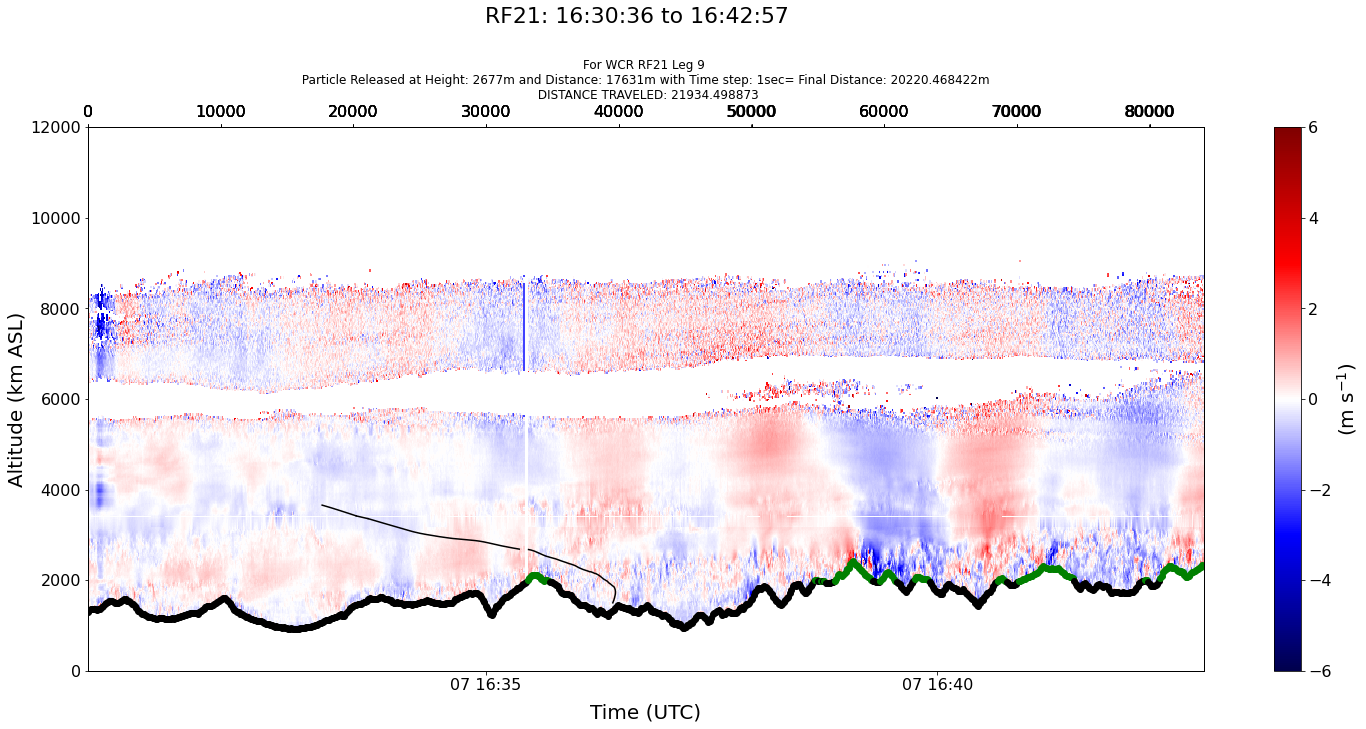

In [68]:
fig, ax = plt.subplots(figsize = (25, 10))

#plotting radar data
cm = ax.pcolormesh(time_subset_2d_wcr, gate_subset_wcr, w_a, vmin = -6, vmax = 6, cmap = 'seismic', rasterized = True)

cbar = plt.colorbar(cm, label = 'm s$^{-1}$)')
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(label='(m s$^{-1}$)',fontsize=20)

ax.set_ylim(0, 12000)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.tick_params(which='both',labelsize=16)

ax.set_ylabel('Altitude (km ASL)',fontsize=20)
ax.set_xlabel('Time (UTC)',fontsize=20, labelpad = 10)
plt.suptitle(rf + ': ' +  str(start_time)[11:19] + ' to ' + str(end_time)[11:19], fontsize = 22, x=.43, y=1.047)

#plottin#plotting terrain and distance
if iop_t[timeidx][3]==0:
    axx= ax.twinx()
    axx.set_ylim(0,12000)
    axx.axes.yaxis.set_visible(False)
    for n in range(flight_leg['topo'].shape[0]-1):
        if flight_leg['topo'].values[n]>1981:
            act_time=df_flight_time_subset[n]
            pt0=df_flight_time_subset[true_i[0]]
            pt1=df_flight_time_subset[true_i[1]]
            #pt2=df_flight_time_subset[true_i[2]]
            pt3=df_flight_time_subset[true_i[-1]]
            if act_time>pt0 and act_time<pt1:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
            elif act_time>pt1 and act_time<pt3:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
            #elif act_time>pt2 and act_time<pt3:
                #axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
            else:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
                #axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        else:
            axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)

            
            
if iop_t[timeidx][3]==1:
    axx=ax.twiny()
    axx.set_ylim(0,12000)
    axx.axes.yaxis.set_visible(False)
    for n in range(flight_leg['topo'].shape[0]-1):
        if flight_leg['topo'].values[n]>1981:
            act_time=df_flight_time_subset[n]
            pt0=df_flight_time_subset[true_i[0]]
            pt1=df_flight_time_subset[true_i[1]]
            #pt2=df_flight_time_subset[true_i[2]]
            pt3=df_flight_time_subset[true_i[-1]]
            if act_time>pt0 and act_time<pt1:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
            elif act_time>pt1 and act_time<pt3:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
            #elif act_time>pt2 and act_time<pt3:
                #axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
            else:
                axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
                #axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        else:
            axx.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
            

axx.set_xlim(df_flight_time_subset[0], df_flight_time_subset[-1])
axx.xaxis.set_visible(False)

axx.set_xlabel('Distance (m)', fontsize=20)
#if west flight
if iop_t[timeidx][3]==1:
    axx.invert_xaxis()
    ax.invert_xaxis()

#plotting trajectory
ax2=ax.twiny()
ax2.plot(xcoord, ycoord, color='black')
ax2.set_xlim(0,distance_wcr[-1])
ax2.tick_params(labelsize=16)

ax2.set_title('For WCR %s Leg %s \n Particle Released at Height: %dm and Distance: %dm with Time step: %dsec= Final Distance: %fm \n DISTANCE TRAVELED: %f'%(rf, leg ,height_initial, real_dist, t, xcoord[-1], total_distance_traveled))
#if flight leg is west
if iop_t[timeidx][3]==1:
    ax2.invert_xaxis()
    
#axv=ax.twiny()
#axv.plot(xcoord3, ycoord3, color='k')
#axv.set_xlim(0,np.max(distance))
#axv.tick_params(which='both',labelsize=16)
#if iop_t[timeidx][3]==1:
    #axv.invert_xaxis()
    
ax3=ax.twiny()
ax3.plot(np.asarray(xcoord_h1)[0:first_value], np.asarray(ycoord_h1)[0:first_value], color='k')
ax3.set_xlim(0,np.max(distance_wcr))
ax3.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax3.invert_xaxis()
    
    
ax4=ax.twiny()
ax4.plot(xcoord_after_h1, ycoord_after_h1, color='k')
ax4.set_xlim(0,np.max(distance_wcr))
ax4.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax4.invert_xaxis()
    
axv=ax.twiny()
axv.plot(xcoord3, ycoord3, color='k')
axv.set_xlim(0,np.max(distance))
axv.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    axv.invert_xaxis()

#plt.savefig('/glade/u/home/kaylee/Newest_traj/WCR/'+rf+'_Leg'+leg+'_S_height_'+str(height_initial)+'S_dist'+str(distance_initial)+'.pdf', format = 'pdf')
plt.savefig('/glade/u/home/kaylee/Trajectories/WRF_HZwind/WCR/WCRRF'+rf+'Leg'+leg+'.pdf', format = 'pdf')

In [ ]:
#if horizontal line interupts

In [786]:
max_topo=np.max(flight_leg['topo'])
lower_topo, upper_topo=height_i(max_topo, gate_subset_wcr)
lower_IPC, upper_IPC= height_i(seeding_height, gate_subset_wcr)
[before_i, after_i]=distance_i(xcoord_after_h4[-1])
w_subset= w_a[before_i,:].squeeze()
indexes=(np.argwhere(np.isnan(w_subset)))
for n in range(indexes.shape[0]):
    if indexes[n,0]< lower_IPC and indexes[n,0]>upper_topo:
        wanted_idx=indexes[n,0]
        
dz_h_gap= 30

pt1_x=xcoord_after_h4[-2]
pt2_x=xcoord_after_h4[-4]
pt1_y= ycoord_after_h4[-2]
pt2_y= ycoord_after_h4[-4]
dx_dz= (pt2_x-pt1_x)/(pt2_y-pt1_y)

new_start_x=xcoord_after_h4[-2]-(dx_dz*dz_h_gap)
#60 because ycoord[-2] is 30 m above where encounters nan
new_start_z=ycoord_after_h4[-2]-60

NameError: name 'xcoord_after_h4' is not defined

In [239]:
height_initial= new_start_z[0]
distance_initial= new_start_x[0]
height_wanted= new_start_z[0]
distance_wanted= new_start_x[0]
t=1
xcoord_horz=[]
ycoord_horz=[]
time=[]
for n in range(100000):
    if distance_wanted< np.max(distance):
        [loweri_wcr, upperi_wcr]=height_i(height_wanted, gate_subset_wcr)
        [loweri_s, upperi_s]= height_i(height_wanted, height_v_sec_sounding_a)
        [before_i, after_i]=distance_i(distance_wanted)
        [time_at_point, before_t_i, after_t_i]=wcr_time_i(before_i, after_i, distance_wanted)
        angle_at_pt=value_at_point_1d(before_i, after_i, distance_wanted, distance, a_subset)
        u_at_pt=value_at_point_1d(loweri_s, upperi_s, height_wanted, height_sounding_a, u_sounding_a)
        v_at_pt=value_at_point_1d(loweri_s, upperi_s, height_wanted, height_sounding_a, v_sounding_a)
        w= final_v(time_at_point,before_t_i, after_t_i, distance_wanted, loweri_wcr, upperi_wcr, height_wanted,w_a)
        T= final_v(time_at_point,before_t_i, after_t_i, distance_wanted, loweri_wcr, upperi_wcr, height_wanted,T_a)
        along_fl_wind= shifted_wind(u_at_pt, v_at_pt, angle_at_pt)
    
        [d, h]=next_position(distance_wanted,height_wanted,w,T,along_fl_wind,t)

        xcoord_horz.append(d)
        ycoord_horz.append(h)
        height_wanted=h
        distance_wanted=d
        if w==np.NaN:
            break

ValueError: zero-size array to reduction operation minimum which has no identity

In [242]:
total_distance_traveled=np.abs(real_dist-xcoord_horz[-1])

NameError: name 'xcoord_h2' is not defined

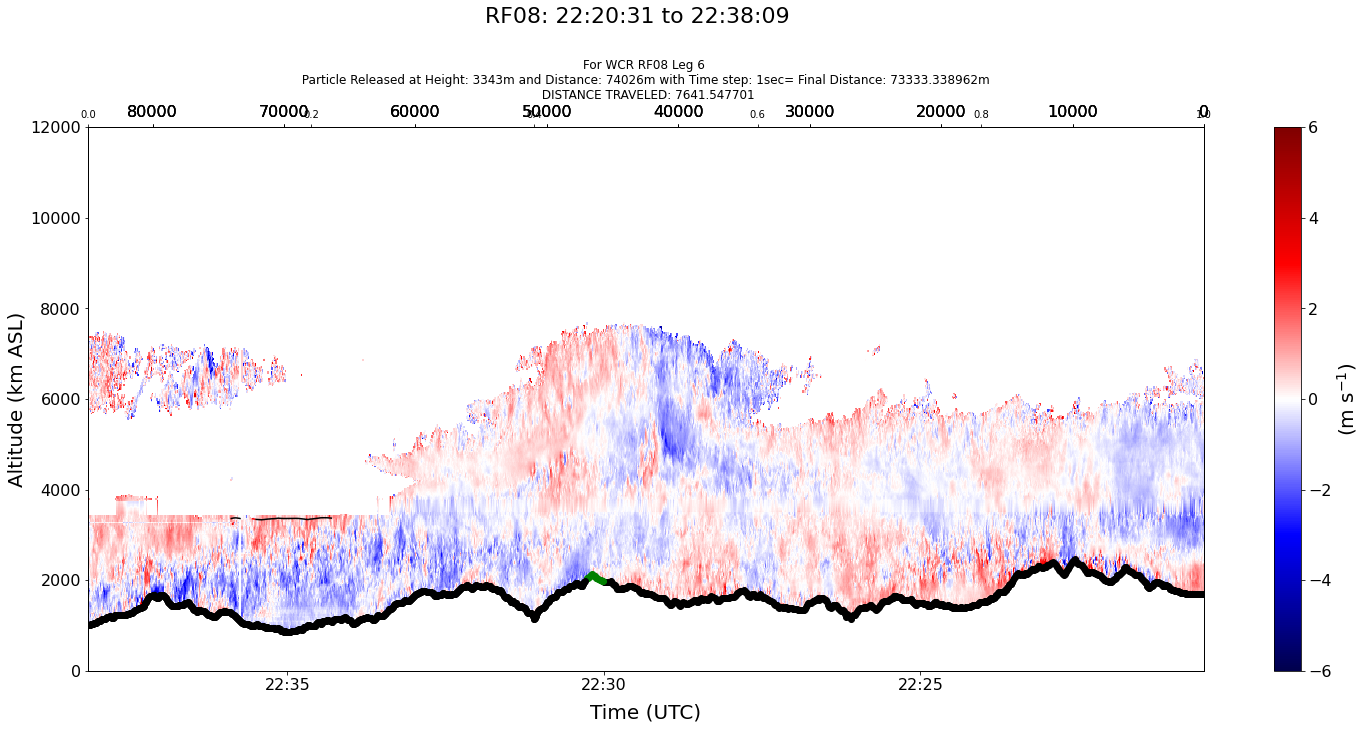

In [95]:
fig, ax = plt.subplots(figsize = (25, 10))

#plotting radar data
cm = ax.pcolormesh(time_subset_2d_wcr, gate_subset_wcr, w_a, vmin = -6, vmax = 6, cmap = 'seismic', rasterized = True)

cbar = plt.colorbar(cm, label = 'm s$^{-1}$)')
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(label='(m s$^{-1}$)',fontsize=20)

ax.set_ylim(0, 12000)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.tick_params(which='both',labelsize=16)

ax.set_ylabel('Altitude (km ASL)',fontsize=20)
ax.set_xlabel('Time (UTC)',fontsize=20, labelpad = 10)
plt.suptitle(rf + ': ' +  str(start_time)[11:19] + ' to ' + str(end_time)[11:19], fontsize = 22, x=.43, y=1.047)

if iop_t[timeidx][3]==1:
    ax.invert_xaxis()

#plotting terrain and distance
if iop_t[timeidx][3]==0:
    axy=ax.twiny()
    for n in range(flight_leg['topo'].shape[0]-1):
        if flight_leg['topo'].values[n]<1981:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        #if flight_leg['topo'].values[n]>=1981:
            #axy.plot(distance[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]>df_flight_time_subset[true_i[0]] and df_flight_time_subset[n]<df_flight_time_subset[true_i[1]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]>df_flight_time_subset[true_i[-1]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        #if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]>df_flight_time_subset[fia[25]] and df_flight_time_subset[n]<df_flight_time_subset[true_i[-1]]:
            #axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        #if flight_leg['topo'].values[n]>=1981 and distance[n]>distance[true_i[3]]:
            #axy.plot(distance[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        #if distance[n]>distance[true_i[-1]]:
           # axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        if df_flight_time_subset[n]<df_flight_time_subset[true_i[0]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        #if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]>df_flight_time_subset[true_i[1]] and df_flight_time_subset[n]<df_flight_time_subset[fia[25]]:
            #axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
            
if iop_t[timeidx][3]==1:
    axy=ax.twiny()
    for n in range(flight_leg['topo'].shape[0]-1):
        if flight_leg['topo'].values[n]<1981:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        #if flight_leg['topo'].values[n]>=1981:
            #axy.plot(distance[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]>df_flight_time_subset[true_i[0]] and df_flight_time_subset[n]<df_flight_time_subset[true_i[1]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        if flight_leg['topo'].values[n]>=1981 and df_flight_time_subset[n]>df_flight_time_subset[fia[21]] and df_flight_time_subset[n]<df_flight_time_subset[true_i[-1]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
       # if flight_leg['topo'].values[n]>=1981 and distance[n]>distance[fia[20]] and distance[n]<distance[true_i[-1]]:
            #axy.plot(distance[n], flight_leg['topo'].values[0:-1][n], 'go', linewidth=4)
        if df_flight_time_subset[n]<df_flight_time_subset[true_i[0]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
        if df_flight_time_subset[n]>df_flight_time_subset[true_i[-1]]:
            axy.plot(df_flight_time_subset[n], flight_leg['topo'].values[0:-1][n], 'ko', linewidth=4)
            

axy.set_xlim(df_flight_time_subset[0], df_flight_time_subset[-1])
axy.xaxis.set_visible(False)

axy.set_xlabel('Distance (m)', fontsize=20)
#if west flight
if iop_t[timeidx][3]==1:
    axy.invert_xaxis()

#plotting trajectory
ax2=ax.twiny()
ax2.plot(xcoord, ycoord, color='black')
ax2.set_xlim(0,distance_wcr[-1])
ax2.tick_params(labelsize=16)

ax2.set_title('For WCR %s Leg %s \n Particle Released at Height: %dm and Distance: %dm with Time step: %dsec= Final Distance: %fm \n DISTANCE TRAVELED: %f'%(rf, leg ,height_initial, real_dist, t, xcoord[-1], total_distance_traveled))
#if flight leg is west
if iop_t[timeidx][3]==1:
    ax2.invert_xaxis()
    
ax3=ax.twiny()
ax3.plot(np.asarray(xcoord_h1)[0:17,0], np.asarray(ycoord_h1)[0:17,0], color='k')
ax3.set_xlim(0,np.max(distance_wcr))
ax3.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax3.invert_xaxis()
    
    
ax4=ax.twiny()
ax4.plot(xcoord_after_h1, ycoord_after_h1, color='k')
ax4.set_xlim(0,np.max(distance_wcr))
ax4.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax4.invert_xaxis()
    
ax5=ax.twiny()
ax5.plot(np.asarray(xcoord_h2)[0:9,0], np.asarray(ycoord_h2)[0:9,0], color='k')
ax5.set_xlim(0,np.max(distance_wcr))
ax5.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax5.invert_xaxis()
    
ax6=ax.twiny()
ax6.plot(xcoord_after_h2, ycoord_after_h2, color='k')
ax6.set_xlim(0,np.max(distance_wcr))
ax6.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax6.invert_xaxis()

ax7=ax.twiny()
ax7.plot(np.asarray(xcoord_h3)[0:58,0], np.asarray(ycoord_h3)[0:58,0], color='r')
ax7.set_xlim(0,np.max(distance_wcr))
ax7.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax7.invert_xaxis()
    
ax8=ax.twiny()
ax8.plot(xcoord_after_h3, ycoord_after_h3, color='k')
ax8.set_xlim(0,np.max(distance_wcr))
ax8.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax8.invert_xaxis()
    
ax9=ax.twiny()
ax9.plot(np.asarray(xcoord_h4)[0:first_value,0], np.asarray(ycoord_h4)[0:first_value,0], color='r')
ax9.set_xlim(0,np.max(distance_wcr))
ax9.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax9.invert_xaxis()
    
ax10=ax.twiny()
ax10.plot(xcoord_after_h4, ycoord_after_h4, color='k')
ax10.set_xlim(0,np.max(distance_wcr))
ax10.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax10.invert_xaxis()
    
axh=ax.twiny()
axh.plot(xcoord_horz, ycoord_horz, color='black')
axh.set_xlim(0,distance_wcr[-1])
axh.tick_params(labelsize=16)
if iop_t[timeidx][3]==1:
    axh.invert_xaxis()
    
ax7=ax.twiny()
ax7.plot(np.asarray(xcoord_h3)[0:first_value,0], np.asarray(ycoord_h3)[0:first_value,0], color='r')
ax7.set_xlim(0,np.max(distance_wcr))
ax7.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax7.invert_xaxis()
    
ax8=ax.twiny()
ax8.plot(xcoord_after_h3, ycoord_after_h3, color='k')
ax8.set_xlim(0,np.max(distance_wcr))
ax8.tick_params(which='both',labelsize=16)
if iop_t[timeidx][3]==1:
    ax8.invert_xaxis()
#plt.savefig('/glade/u/home/kaylee/Newest_traj/WCR/'+rf+'_Leg'+leg+'_S_height_'+str(height_initial)+'S_dist'+str(distance_initial)+'.pdf', format = 'pdf')

In [ ]:
#run this for 2nd interuption

In [318]:
#run this to out distance traveled into CSV

In [124]:
df_distances=pd.read_csv('/glade/u/home/kaylee/Trajectories/WRF_HZwind/WCR_dist_traveled.csv')

In [125]:
df_distances

,Unnamed: 0,Distance Traveled,RF,Leg
0,0,55319.021510,1,6
1,1,60726.065514,1,6
2,2,60728.266347,1,7
3,3,64749.268898,1,8
4,4,45389.877281,1,9
...,...,...,...,...
61,61,24029.677204,21,7
62,62,24047.779280,21,7
63,63,21934.498873,21,9
64,64,20584.785052,21,10


In [126]:
df_distances=df_distances[['Distance Traveled', 'RF', 'Leg']]

In [127]:
df_distances

,Distance Traveled,RF,Leg
0,55319.021510,1,6
1,60726.065514,1,6
2,60728.266347,1,7
3,64749.268898,1,8
4,45389.877281,1,9
...,...,...,...
61,24029.677204,21,7
62,24047.779280,21,7
63,21934.498873,21,9
64,20584.785052,21,10


In [128]:
#df_distances= pd.DataFrame({'Distance Traveled':[], 'RF':[], 'Leg':[]})
data=[{'Distance Traveled': str(total_distance_traveled[0]), 'RF': str(rf2), 'Leg': str(leg)}]
#data=[{'Distance Traveled': str(60726.065514), 'RF': str(1), 'Leg': str(6)}]

df_distances=df_distances.append(data, ignore_index=True)

In [129]:
df_distances

,Distance Traveled,RF,Leg
0,55319,1,6
1,60726.1,1,6
2,60728.3,1,7
3,64749.3,1,8
4,45389.9,1,9
...,...,...,...
62,24047.8,21,7
63,21934.5,21,9
64,20584.8,21,10
65,20561.8,21,10


In [130]:
df_distances.to_excel('/glade/u/home/kaylee/Trajectories/WRF_HZwind/WCR_dist_traveled.xlsx')
df_distances.to_csv('/glade/u/home/kaylee/Trajectories/WRF_HZwind/WCR_dist_traveled.csv')

In [211]:
#creating a CSV
import csv
df=pd.DataFrame(columns=["Distance Traveled", "RF", "Leg"])
df.to_csv('/glade/u/home/kaylee/Trajectories/WRF_HZwind/WCR_dist_traveled.csv')

In [ ]:
#removing a row

In [457]:
import csv
with open('/glade/u/home/kaylee/Trajectories/WRF_HZwind/WCR_dist_traveled.csv', 'r') as inp, open('/glade/u/home/kaylee/Trajectories/WRF_HZwind/WCR_dist_traveled2.csv', 'w') as out:
    writer = csv.writer(out)
    for row in csv.reader(inp):
        if row != ['4','nan','1', '9']:
            print(row)
            writer.writerow(row)
        if row==['4','nan','1', '9']:
            print('no')
            #writer.writerow(row)

['', 'Distance Traveled', 'RF', 'Leg']
['0', '55319.021510065286', '1', '6']
['1', '60726.065514', '1', '6']
['2', '60728.26634660245', '1', '7']
['3', '64749.26889826218', '1', '8']
no


In [427]:
read_file = pd.read_excel ('/glade/u/home/kaylee/Newest_traj/WCR_dist_traveled.xlsx', engine='openpyxl')
read_file.to_csv ('/glade/u/home/kaylee/Newest_traj/WCR_dist_traveled.csv', index = None, header=True)